# Investment strategy in Python

"""
Created on Fri Dec  18 18:09:11 2021
@author: Eva Cheng - DMF Student 2021 - 2022
"""

The purpose of this project is to better understand how we can simulate some investment strategies by using python programming. For this project I will try to show different securities (bonds, stocks, options and Forex if I have time to cover everything). The strategy will be based on technical analysis, cointegration (for the ETF), Arima model, bond pricing, linear regression, arowitz optimization and SVM model. Those models are pretty well known and used in the scope of asset pricing. For this project, I will use these different datasets :
- A dataset of CAC40 prices history from EIKON
- A dataset of American and French governement bonds from EIKON
- A dataset of the EUR/USD Forex from Yahoo
- A dataset of the EUR/GBP Forex from Yahoo
- A dataset of the EUR/HKD Forex from Yahoo
- A dataset of the EUR/JPY Forex from Yahoo
- A dataset about the inflation in France from Macro trends

One of the investment strategies will be based on an article of Carol Alexander and Anca Dimitriu, and readapted to the CAC40 that can be read here : https://papers.ssrn.com/sol3/papers.cfm?abstract_id=315619 it will be implemented in the IV a. 4) if I manage to finish the project beforehands and if the other parts are not too long. If not, well the article is still interesting 😉. (not covered)

## Guidelines
The project will we conducted in the following way :
- Importing the libraries, the datasets and configuring the the directory
- Showing some plots to better understand the guidelines and the strategies
- Bond pricing without and within inflation, comparing how much return we can get out of the bonds.
- Technical analysis of the CAC 40
- Linear regression of Moving average of the CAC40
- Finding the stocks that are correlated to cac40 in case someone wants to copy the CAC 40
- Selecting a diversified portfolio
- ARIMA model with the portfolio
- Markowitz frontier
- Optimization of the allocation of the portfolio
- Selecting Foreign Currencies
- Linear model with Forex
- Conclusion

## I. Importing the datasets and configuration
Based on what have been presented above, I will now load the different datasets to begin my analysis. The point of taking such different securities is to allow the user to diversify their portfolio.

### a. Libraries
These are the library that will be used for the simulation. 

In [1]:
# Import the libraries and the modules that will be used
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display_html
import datetime
from datetime import date
from datetime import datetime
from sklearn import linear_model
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import random

# Don't forget to install cvxopt (pip install cvxopt from the anaconda prompt otherwise it will not work)
from cvxopt import matrix, solvers
from matplotlib.pyplot import figure
from scipy.stats import norm

### b. Configuration
This part will be about the good configuration of the pathway, the importation of the datasets, the suppression of the warning messages and other useful features such as global variables that can be modified easily.

In [2]:
# Eliminating the waring messages 
warnings.filterwarnings("ignore")
# This line of code helps the user setting the current directory (so they don't have to write the whole directory everytime)
os.chdir("C:/Users/33652/Desktop/Git_repo_LOCAL/Investment_strat")

# Importation of the dataset zone
cac_data_prices = pd.read_excel("data/cac40.xlsx", parse_dates=['Date'], index_col='Date')
bond_prices = pd.read_excel("data/bonds_today.xlsx")
eurgbp = pd.read_csv("data/eur_to_gbp.csv", parse_dates=['Date'], index_col='Date')
eurusd = pd.read_csv("data/eur_to_usd.csv", parse_dates=['Date'], index_col='Date')
eurhkd = pd.read_csv("data/eur_to_hkd.csv", parse_dates=['Date'], index_col='Date')
eurjpy = pd.read_csv("data/eur_to_jpy.csv", parse_dates=['Date'], index_col='Date')
inflation = pd.read_csv("data/france-inflation.csv", parse_dates=['Date'], index_col='Date')

# Set size of the plots
plt.rcParams["figure.figsize"] = (13,7)

Let us show the head of each dataframe :

In [3]:
# This represents the dataset of the CAC40
cac_data_prices.head()

,Time in days,AIRP.PA,AXAF.PA,BOUY.PA,BNPP.PA,TCFP.PA,CAPP.PA,ESLX.PA,OREP.PA,LVMH.PA,...,VIE.PA,VIV.PA,EUFI.PA,CAGR.PA,MT.AS,ENGIE.PA,LEGD.PA,WLN.PA,STLA.PA,CAC40
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-27,0,78.428267,17.510,30.400,49.410,44.385,52.48,77.87,125.90,126.487209,...,13.734616,7.444825,22.300,10.600,25.240572,19.702120,44.955,16.4,5.831555,4436.99
2014-06-30,1,79.370082,17.455,30.390,49.545,44.175,52.10,77.45,125.85,126.892762,...,13.416439,7.384903,22.460,10.300,25.194046,19.556214,44.685,16.6,5.717678,4422.84
2014-07-01,2,80.239450,17.575,30.345,51.330,44.360,52.65,78.07,125.90,127.073007,...,13.618915,7.494416,22.240,10.605,25.426678,19.609713,44.890,16.4,5.892466,4461.12
2014-07-02,3,80.175053,17.590,29.750,51.010,43.955,52.88,77.27,125.60,126.126719,...,13.223605,7.417963,22.625,10.560,25.833784,19.585395,44.760,16.3,5.937487,4444.72
2014-07-03,4,81.382508,18.150,30.310,51.250,44.300,55.74,77.63,127.25,127.839050,...,13.209143,7.550205,22.980,10.705,26.264153,19.658348,45.415,16.4,6.040770,4489.88


The dataset above represents the closing prices of each stocks in the CAC40 and the closing price of the CAC40 as well, it starts from the 27th of June 2014 and it goes until today.

In [4]:
# This is the bond price collected on the 27th of december 2021
bond_prices

,Maturity in years,Country,Bid Price,Coupon rate,Yield
0,0.083333,France,100.065000,0.000,-0.668137
1,0.250000,France,100.164000,0.000,-0.765498
2,0.750000,France,100.475000,0.000,-0.607827
3,1.000000,France,100.552000,0.000,-0.588182
4,1.000000,US,99.736333,0.000,0.297000
5,5.000000,France,103.870000,0.500,-0.370177
6,5.000000,US,100.000000,1.250,1.250000
7,10.000000,France,98.710000,0.000,0.131146
8,10.000000,US,99.062500,1.375,1.477000


This represents the 1 month, 3 months, 9 months, 1 year, 5 years and 10 years bonds of the US and French government that had interesting features.

In [5]:
# Displaying the EUR / GBP
eurgbp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-28,0.89926,0.90885,0.89890,0.89920,0.89920,0
2020-12-29,0.90727,0.90907,0.90572,0.90726,0.90726,0
2020-12-30,0.90776,0.90840,0.90024,0.90759,0.90759,0
2020-12-31,0.90231,0.90300,0.89465,0.90236,0.90236,0
2021-01-01,0.88419,0.88515,0.88382,0.88492,0.88492,0


In [6]:
# Displaying the EUR / USD
eurusd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-28,1.220703,1.225200,1.218353,1.220510,1.220510,0
2020-12-29,1.222001,1.227599,1.222001,1.222345,1.222345,0
2020-12-30,1.225325,1.230875,1.225205,1.225295,1.225295,0
2020-12-31,1.229906,1.230951,1.222300,1.229990,1.229990,0
2021-01-01,1.217285,1.221699,1.213499,1.218027,1.218027,0


## II. First plots and overview
Let us plot some graphs to see if there is an eventual trend and see if there are things we can invest in of course, here the prices are taken in account but later, everything will be transformed into returns to better model the predictions.

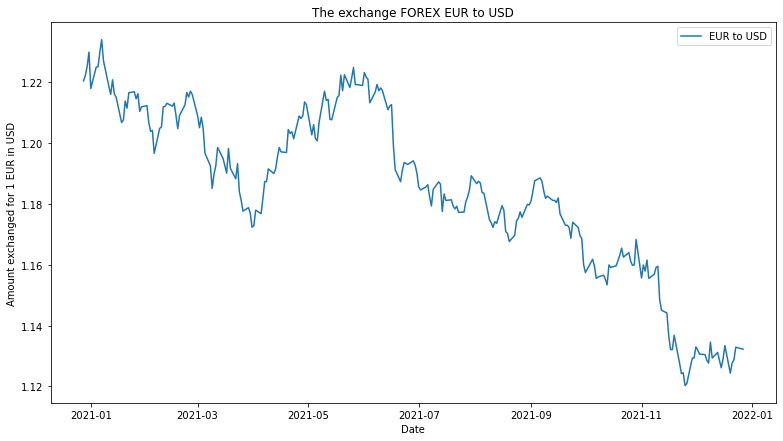

In [7]:
# Plot FOREX
plt.clf()
plt.plot(eurusd['Close'], label = "EUR to USD")
plt.legend()
plt.title("The exchange FOREX EUR to USD")
plt.xlabel("Date")
plt.ylabel("Amount exchanged for 1 EUR in USD")
plt.show()

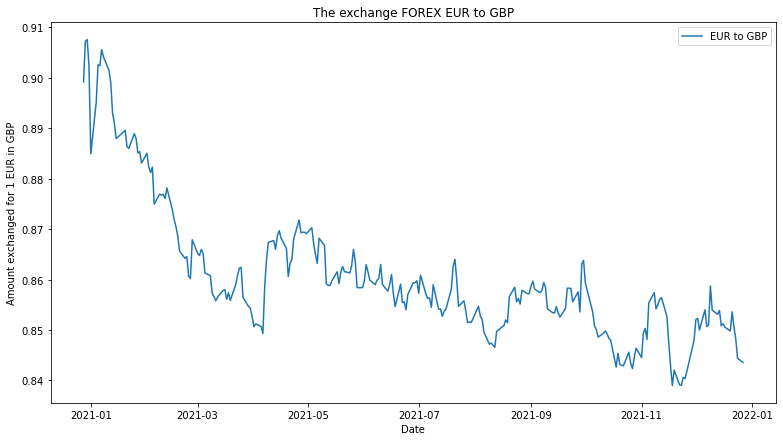

In [8]:
# Plot FOREX
plt.clf()
plt.plot(eurgbp['Close'], label = "EUR to GBP")
plt.legend()
plt.title("The exchange FOREX EUR to GBP")
plt.xlabel("Date")
plt.ylabel("Amount exchanged for 1 EUR in GBP")
plt.show()

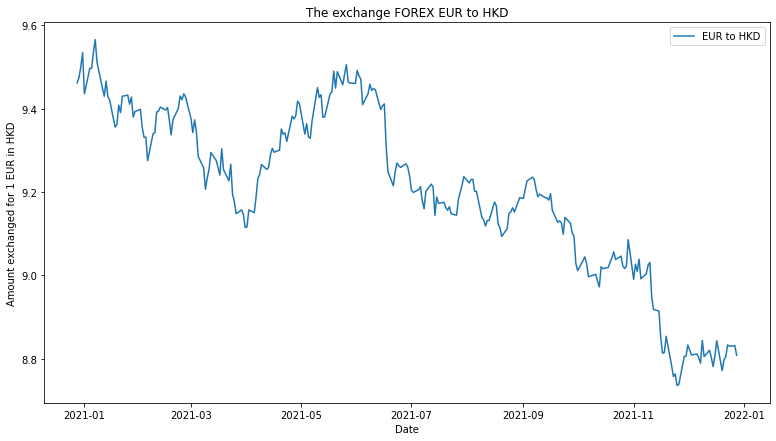

In [9]:
# Plot FOREX
plt.clf()
plt.plot(eurhkd['Close'], label = "EUR to HKD")
plt.legend()
plt.title("The exchange FOREX EUR to HKD")
plt.xlabel("Date")
plt.ylabel("Amount exchanged for 1 EUR in HKD")
plt.show()

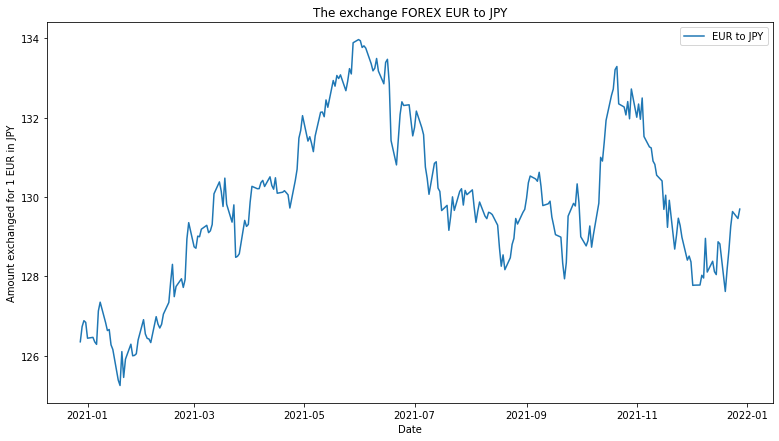

In [10]:
# Plot FOREX
plt.clf()
plt.plot(eurjpy['Close'], label = "EUR to JPY")
plt.legend()
plt.title("The exchange FOREX EUR to JPY")
plt.xlabel("Date")
plt.ylabel("Amount exchanged for 1 EUR in JPY")
plt.show()

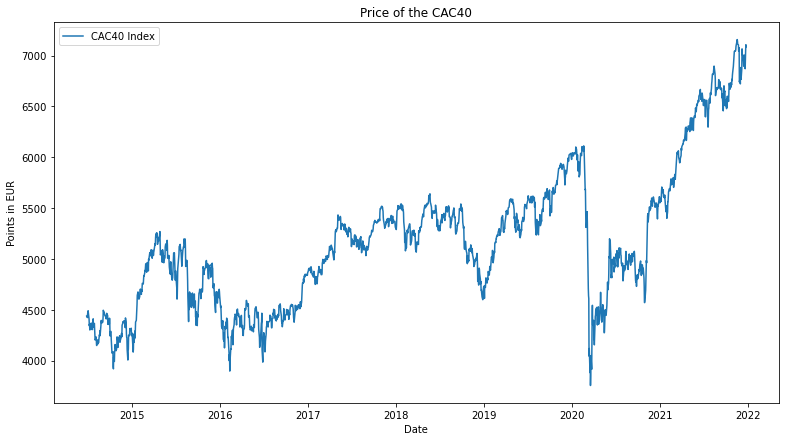

In [11]:
# Plot CAC40
plt.clf()
plt.plot(cac_data_prices['CAC40'], label = "CAC40 Index")
plt.legend()
plt.title("Price of the CAC40")
plt.xlabel("Date")
plt.ylabel("Points in EUR")
plt.show()

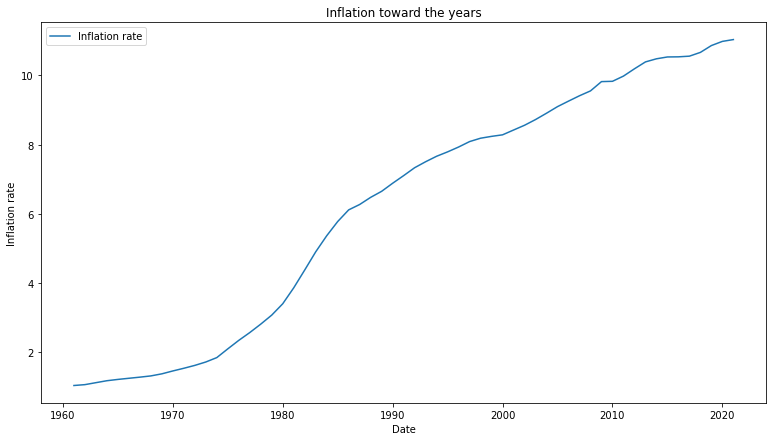

In [12]:
# Plot Cumulative inflation rate
plt.clf()
plt.plot(inflation['Multiplier'], label = "Inflation rate")
plt.legend()
plt.title("Inflation toward the years")
plt.xlabel("Date")
plt.ylabel("Inflation rate")
plt.show()

At the first sight, we can say that Euro is loosing value so it might be better to invest in Foreign Exchange such as US dollar, HK dollar or GB Pound. The CAC40 seems to have an upward trend so we may choose to analyze some strategies to invest in this index or stocks related to this index. Air France stock is going down so investing in put options or being short (future) might be a solution. Since we have an overview of the equities, forex (risky assets) we may begin our analysis.

## III. Fixed Income
I want to start my analysis be presenting the fixed income because I have chosen to allow the user to invest in fixed income such as bonds. The inflation will be taken in account if the time and the memory taken by the project allows it. Here I have French and US government bonds.

In [13]:
# Let's create functions that can be used later (in case the user wants to test something)
def coupon_amount(cpn_rate, par_val):
    return cpn_rate * par_val

def get_price_bond(coupon, n, rate, par_val):
    return coupon / rate * (1 - (1 + rate)**(-n)) + par_val * (1 + rate)**(-n)

def get_profit_bond(par_val, price_bond):
    return par_val - price_bond

Let's use the data in the dataset to see the profit that can be made out of each bond and try to find a balance with time the investor wants to invest, the inflation...

### a. Creating a linear model for the inflation prediction
Sicne the inflation seems to be a linear so I can fit a linear model for the inflation rate. Let's create a new column that will be counting the years from the first year in the dataset. 

In [14]:
# Let's create the number of year from the start (it will be used as the x for the linear regression), get the number of days
inflation['years_from_start'] = (inflation.index - inflation.index[0]).days; inflation
# Converting the days in years
inflation['years_from_start'] = round(inflation['years_from_start']/365.25,0)
inflation.head()

,Inflation,Multiplier,Cumulated inflation,years_from_start
Date,,,,
1960-12-31,4.14%,1.041399,4.14%,0.0
1961-12-31,2.40%,1.066398,6.64%,1.0
1962-12-31,5.33%,1.123251,12.33%,2.0
1963-12-31,5.00%,1.179404,17.94%,3.0
1964-12-31,3.21%,1.217277,21.73%,4.0


In [15]:
# First year and current year
first_year = inflation.index[0].to_pydatetime().date().year
# 2021
today = date.today().year
# 2021 - 1960
year_from_first = today - first_year

Since we have 10 year bonds, we have to go until today's date + 10 years. We have to create a dateframe counting the years from start (from 1960 starting 2021).

In [16]:
# Creating a list that contains all the year of the 
years_from_start = []
years = []
# 2021 to 2032
for i in range(12):
    years.append(today + i)
    years_from_start.append(year_from_first + i)

Now, let us create our linear model that predicts the inflation multiplier toward the years.

<Figure size 936x504 with 0 Axes>

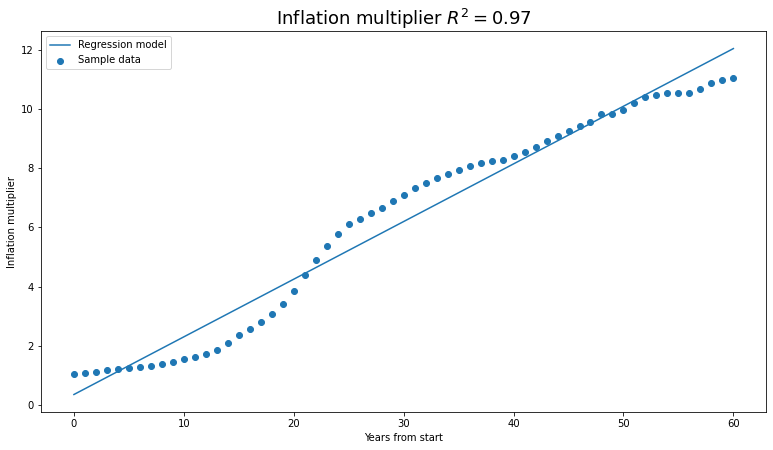

In [17]:
# Here we fit the model
X_train_inflation = inflation['years_from_start'].values.reshape(-1,1)
Y_train_inflation = inflation['Multiplier'].values
ols = linear_model.LinearRegression()
model_inflation = ols.fit(X_train_inflation, Y_train_inflation)
response_inflation = model_inflation.predict(X_train_inflation)
r2 = model_inflation.score(X_train_inflation, Y_train_inflation)

# Try to plot the model and evaluate the goodness of the fit
plt.clf()
fig, ax_inf = plt.subplots()
ax_inf.plot(X_train_inflation, response_inflation, label='Regression model')
ax_inf.scatter(X_train_inflation, Y_train_inflation, label='Sample data')
ax_inf.set_title('Inflation multiplier $R^2= %.2f$' % r2, fontsize=18)
plt.legend()
plt.xlabel("Years from start")
plt.ylabel("Inflation multiplier")
plt.show()

We can see that the R² is pretty good and the line is close to the points so we can say that the inflation follows a linear model. Therefore we can predict the future inflation. 

In [18]:
# Create the predictions
X_test_inf = pd.DataFrame(years_from_start)
Y_predicted = model_inflation.predict(X_test_inf)
multiplier = Y_predicted.tolist()

# Create the dataframe of the predictions 
data_inflation = pd.DataFrame({'Year':years, 'Years from start':years_from_start, 'Multiplier':multiplier})
Multiplier_2021 = data_inflation['Multiplier'][data_inflation['Year']==2021].values
data_inflation['Change from 2021'] = data_inflation['Multiplier']/Multiplier_2021 - 1
data_inflation.tail()

,Year,Years from start,Multiplier,Change from 2021
7,2028,68,13.602318,0.111467
8,2029,69,13.797197,0.127391
9,2030,70,13.992076,0.143315
10,2031,71,14.186954,0.159238
11,2032,72,14.381833,0.175162


Now I should go back to the the price of the bonds and try to see which bond is / are the most interesting to invest in depending on the investment time. I the dataset that have been provided, we have some US bonds but I will use the french inflation rate because the prices are in Euro and because there will be too much dataset and things to take in account. Therefore, the prediction will somehow be false.

### b. Pricing the bonds
I will suppose that when investors invest in bonds in my project, they keep the bond until the end of the period (until maturity) otherwise it may be a mess and there will be a lot of factors.

In [19]:
# Coupon amount and price of the bond
bond_prices['Coupon'] = coupon_amount(bond_prices['Bid Price'], bond_prices['Coupon rate']/100)
bond_prices['Price'] = get_price_bond(bond_prices['Coupon'], bond_prices['Maturity in years'], bond_prices['Yield']/100
                                      , bond_prices['Bid Price'])
# Value of the bond in the future
bond_prices['Future value'] = bond_prices['Bid Price'] * (1+bond_prices['Yield']/100)**bond_prices['Maturity in years']

# Supposing that you keep and do not reinvest the money
bond_prices['Profit'] = bond_prices['Future value'] - bond_prices['Price']
# Compare all the years and assign the inflation rate
for i in range(12):
    bond_prices.loc[round(bond_prices['Maturity in years']) == i, 'Inflation'] = data_inflation['Change from 2021'][i]*1.000

# Divide by the inflation rate
bond_prices['FV deflated'] = bond_prices['Future value'] / (1 + bond_prices['Inflation'])
bond_prices['Prof. deflated'] = bond_prices['FV deflated'] - bond_prices['Price']
bond_prices

,Maturity in years,Country,Bid Price,Coupon rate,Yield,Coupon,Price,Future value,Profit,Inflation,FV deflated,Prof. deflated
0,0.083333,France,100.065000,0.000,-0.668137,0.000000,100.120917,100.009114,-0.111802,0.000000,100.009114,-0.111802
1,0.250000,France,100.164000,0.000,-0.765498,0.000000,100.356611,99.971759,-0.384852,0.000000,99.971759,-0.384852
2,0.750000,France,100.475000,0.000,-0.607827,0.000000,100.935485,100.016615,-0.918870,0.015924,98.448931,-2.486555
3,1.000000,France,100.552000,0.000,-0.588182,0.000000,101.146928,99.960571,-1.186357,0.015924,98.393765,-2.753163
4,1.000000,US,99.736333,0.000,0.297000,0.000000,99.440993,100.032550,0.591557,0.015924,98.464615,-0.976378
5,5.000000,France,103.870000,0.500,-0.370177,0.519350,108.439889,101.961667,-6.478222,0.079619,94.442250,-13.997638
6,5.000000,US,100.000000,1.250,1.250000,1.250000,100.000000,106.408215,6.408215,0.079619,98.560877,-1.439123
7,10.000000,France,98.710000,0.000,0.131146,0.000000,97.424747,100.012209,2.587462,0.159238,86.274065,-11.150682
8,10.000000,US,99.062500,1.375,1.477000,1.362109,98.129519,114.705827,16.576307,0.159238,98.949299,0.819780


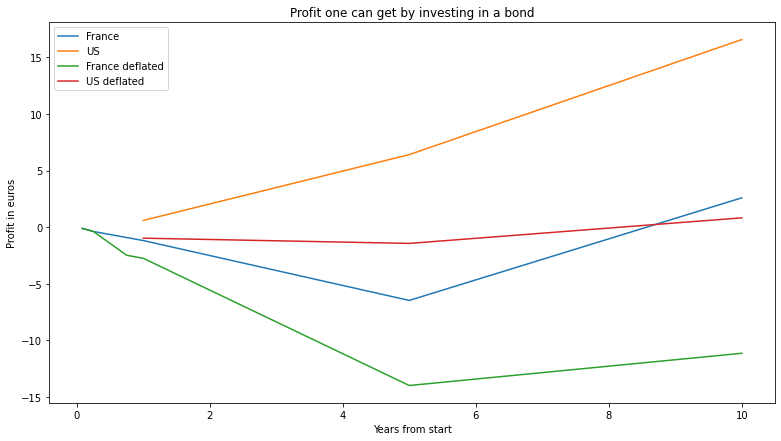

In [20]:
# Separate the US from the French bonds
US_bond = bond_prices[bond_prices['Country']=='US']
FRANCE_bond = bond_prices[bond_prices['Country']=='France']

# Plotting the profit of each different options
plt.clf()
plt.plot(FRANCE_bond['Maturity in years'], FRANCE_bond['Profit'], label = "France")
plt.plot(US_bond['Maturity in years'], US_bond['Profit'], label = "US")
plt.plot(FRANCE_bond['Maturity in years'], FRANCE_bond['Prof. deflated'], label = "France deflated")
plt.plot(US_bond['Maturity in years'], US_bond['Prof. deflated'], label = "US deflated")
plt.legend()
plt.title("Profit one can get by investing in a bond")
plt.xlabel("Years from start")
plt.ylabel("Profit in euros")
plt.show()

In [21]:
# Try to do some test with 100 € not invested 
print("If 100€ not invested within 1 year, profit will be : ", str(100/(1 + data_inflation['Change from 2021'][1]) - 100))
print("If 100€ not invested within 5 years, profit will be : ", str(100/(1 + data_inflation['Change from 2021'][5]) - 100))
print("If 100€ not invested within 10 years, profit will be : ", str(100/(1 + data_inflation['Change from 2021'][10]) - 100))

If 100€ not invested within 1 year, profit will be :  -1.567424535311389
If 100€ not invested within 5 years, profit will be :  -7.374748224221406
If 100€ not invested within 10 years, profit will be :  -13.736466620292063


If we reinvest the money and ignore the effect of inflation, we can investment in the bonds that have positive profits (US bonds that have a maturity higher than 1 year, and French 10-government bond). If the inflation is taken in account, we know that we should not invest in French bonds, French bonds do not seem to be a good investment. We can recommend to invest in US bonds to have stable income and to reinvest the cash obtained from the investment (coupons and the cash back).

If we compare investing to not investing, we can say that investing in French bonds is not worth it unless the investment time is 10 years because the loss is greater when people invest in French government bond. US bonds are more profitable to invest in if we take in account the inflation.

## IV. Equity (CAC40 and stocks of the CAC40)
To begin we should change all the prices into returns because it is better to work with the return instead of the prices since it will be bias and since it is difficult to make predictions about prices.


In [22]:
# Create the returns
return_cac = cac_data_prices.loc[:, cac_data_prices.columns != 'Time in days'].pct_change()
# Removing the NaN values
return_cac.dropna(inplace=True)

# Create the cumulative returns
cummulative_returns = (1 + return_cac).cumprod() - 1
cummulative_returns

,AIRP.PA,AXAF.PA,BOUY.PA,BNPP.PA,TCFP.PA,CAPP.PA,ESLX.PA,OREP.PA,LVMH.PA,MICP.PA,...,VIE.PA,VIV.PA,EUFI.PA,CAGR.PA,MT.AS,ENGIE.PA,LEGD.PA,WLN.PA,STLA.PA,CAC40
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-30,0.012009,-0.003141,-0.000329,0.002732,-0.004731,-0.007241,-0.005394,-3.971406e-04,0.003206,-0.008522,...,-0.023166,-0.008049,0.007175,-0.028302,-0.001843,-0.007406,-0.006006,0.012195,-0.019528,-0.003189
2014-07-01,0.023094,0.003712,-0.001809,0.038859,-0.000563,0.003239,0.002568,-1.110223e-16,0.004631,0.003181,...,-0.008424,0.006661,-0.002691,0.000472,0.007373,-0.004690,-0.001446,0.000000,0.010445,0.005438
2014-07-02,0.022272,0.004569,-0.021382,0.032382,-0.009688,0.007622,-0.007705,-2.382844e-03,-0.002850,0.006704,...,-0.037206,-0.003608,0.014574,-0.003774,0.023502,-0.005924,-0.004338,-0.006098,0.018165,0.001742
2014-07-03,0.037668,0.036551,-0.002961,0.037239,-0.001915,0.062119,-0.003082,1.072280e-02,0.010688,0.011930,...,-0.038259,0.014155,0.030493,0.009906,0.040553,-0.002222,0.010232,0.000000,0.035876,0.011920
2014-07-04,0.042800,0.033981,-0.010033,0.015989,-0.001464,0.043445,-0.008090,8.737093e-03,0.003563,0.002841,...,-0.040014,0.007494,0.018161,0.003774,0.039171,-0.006912,0.016795,-0.003049,0.024069,0.007210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-20,0.908241,0.420902,-0.005592,0.141874,0.613608,2.889101,1.313343,2.264496e+00,4.516763,0.545279,...,1.279641,0.509774,3.898655,0.122264,0.099817,-0.352455,1.210210,1.795122,1.707683,0.548370
2021-12-21,0.910536,0.451171,0.001316,0.191257,0.646052,2.891006,1.334660,2.295473e+00,4.546015,0.587320,...,1.297844,0.577606,3.852018,0.148491,0.130719,-0.342609,1.212435,1.927744,1.795138,0.569756
2021-12-22,0.916911,0.458310,0.004605,0.201174,0.672187,3.032012,1.382432,2.328038e+00,4.655908,0.610612,...,1.313133,0.592381,3.840359,0.155849,0.146963,-0.347177,1.226671,1.964939,1.819145,0.589291


### a. CAC40
#### 1) Technical analysis
The idea of the technical analysis is to analyze the statistical parameters of the equity and try to say if one should invest in a particular stock or index. Of course, I will not suggest to invest in CAC40 because it might be expensive, but one can invest in a ETF that has the same returns as the CAC40 if the CAC40 shows good results.

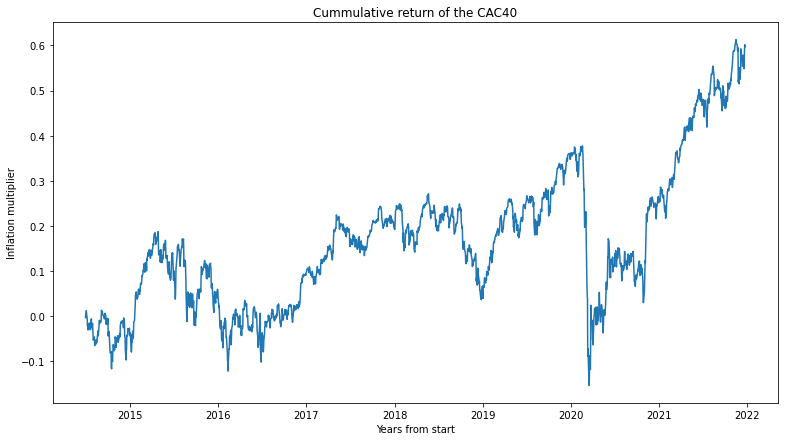

In [23]:
# Plot the cumulative return of the CAC40
plt.clf()
plt.plot(cummulative_returns['CAC40'], label = "Cummulative return of the CAC 40")
plt.title("Cummulative return of the CAC40")
plt.xlabel("Years from start")
plt.ylabel("Inflation multiplier")
plt.show()

Let's try to smooth the graph by using the Moving average, during the class, we learn how to do a moving average according to the stock price but I will be trying to do this with the cummulative return and try to compare the different moving average I get.

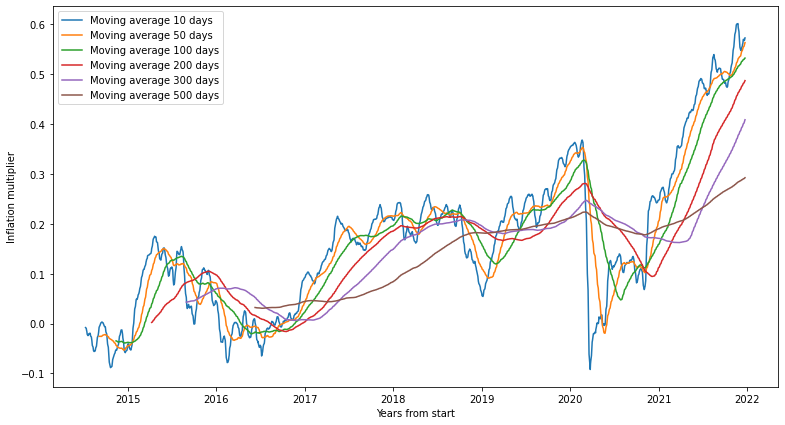

In [24]:
# Moving average
MA_cac = cummulative_returns[['CAC40']]
MA_cac['10 days'] = cummulative_returns['CAC40'].rolling(window=10, min_periods=10, center=False).mean()
MA_cac['50 days'] = cummulative_returns['CAC40'].rolling(window=50, min_periods=50, center=False).mean()
MA_cac['100 days'] = cummulative_returns['CAC40'].rolling(window=100, min_periods=100, center=False).mean()
MA_cac['200 days'] = cummulative_returns['CAC40'].rolling(window=200, min_periods=200, center=False).mean()
MA_cac['300 days'] = cummulative_returns['CAC40'].rolling(window=300, min_periods=300, center=False).mean()
MA_cac['500 days'] = cummulative_returns['CAC40'].rolling(window=500, min_periods=500, center=False).mean()

# Plotting the MA 
plt.clf()
plt.plot(MA_cac['10 days'], label = "Moving average 10 days")
plt.plot(MA_cac['50 days'], label = "Moving average 50 days")
plt.plot(MA_cac['100 days'], label = "Moving average 100 days")
plt.plot(MA_cac['200 days'], label = "Moving average 200 days")

# 1 year and more
plt.plot(MA_cac['300 days'], label = "Moving average 300 days")
# 2 years in trading days
plt.plot(MA_cac['500 days'], label = "Moving average 500 days")
plt.legend()
plt.xlabel("Years from start")
plt.ylabel("Inflation multiplier")
plt.show()

From this we can see that there is a cycle (every two years, the market goes down) but there is also an upward trend, the idea is to invest in the CAC for more than 2 years if one chooses a middle term investment. Let's see what one can do in a short term investment by taking the monthly average return.

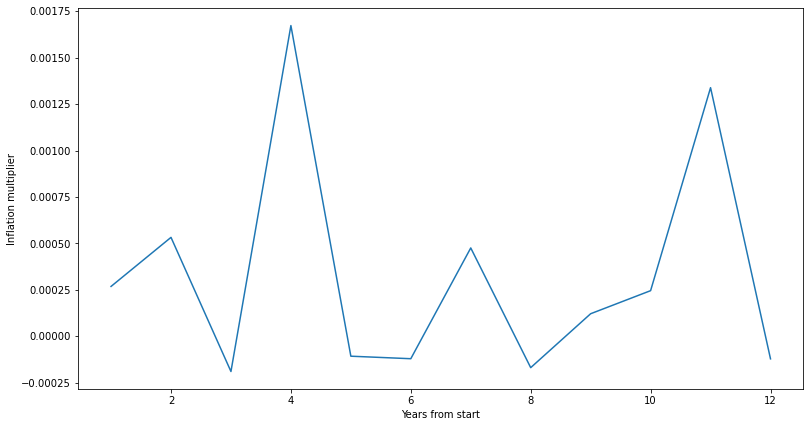

In [25]:
monthly_cac_ret = return_cac[['CAC40']]
monthly_cac_ret['month'] = monthly_cac_ret.index.month
monthly_cac_ret = monthly_cac_ret.groupby('month')['CAC40'].mean()

plt.clf()
plt.plot(monthly_cac_ret, label = "Cummulative return of the CAC 40")
plt.xlabel("Years from start")
plt.ylabel("Inflation multiplier")
plt.show()

The best periods to buy CAC40 index ETF would be during March, May, June, August and it is better to sell them in April or November to get a higher return out of the investment. This is a short term solution to invest in CAC40.

#### 2) Linear regression with Moving Average factors for prediction
One really common linear regression used in case of equity return prediction is the moving average factor where we use many moving average as factors (2, 4, 8, 32, 64 and 128 days) to predict future return in a fixed rolling window. 

In [26]:
# Create the matrix with the return and the moving average
matrix_returns = cac_data_prices[['Time in days']]
matrix_returns['Return'] = return_cac[['CAC40']]
matrix_returns['MA_2'] = matrix_returns['Return'].rolling(window=2, min_periods=2, center=False).mean()
matrix_returns['MA_4'] = matrix_returns['Return'].rolling(window=4, min_periods=4, center=False).mean()
matrix_returns['MA_8'] = matrix_returns['Return'].rolling(window=8, min_periods=8, center=False).mean()
matrix_returns['MA_16'] = matrix_returns['Return'].rolling(window=16, min_periods=16, center=False).mean()
matrix_returns['MA_32'] = matrix_returns['Return'].rolling(window=32, min_periods=32, center=False).mean()
matrix_returns['MA_64'] = matrix_returns['Return'].rolling(window=64, min_periods=64, center=False).mean()
matrix_returns['MA_128'] = matrix_returns['Return'].rolling(window=128, min_periods=128, center=False).mean()
matrix_considered = matrix_returns.dropna()
matrix_considered

,Time in days,Return,MA_2,MA_4,MA_8,MA_16,MA_32,MA_64,MA_128
Date,,,,,,,,,
2014-12-24,128,-0.004431,0.004899,0.002742,0.005715,-0.001181,0.000630,-0.000116,-0.000182
2014-12-29,129,0.005140,0.000354,0.004488,0.009508,-0.000910,0.000633,-0.000177,-0.000117
2014-12-30,130,-0.016765,-0.005813,-0.000457,0.004671,-0.000991,0.000582,-0.000309,-0.000315
2014-12-31,131,0.006409,-0.005178,-0.002412,0.004901,-0.001972,0.000722,-0.000417,-0.000237
2015-01-02,132,-0.004788,0.000810,-0.002501,0.000120,-0.001649,0.000464,-0.000312,-0.000353
...,...,...,...,...,...,...,...,...,...
2021-12-20,1915,-0.008161,-0.009679,-0.000873,-0.002574,0.001272,-0.000453,0.000796,0.000420
2021-12-21,1916,0.013812,0.002825,0.001408,-0.000734,0.001796,-0.000259,0.000811,0.000433
2021-12-22,1917,0.012445,0.013129,0.001725,0.001117,0.003082,0.000100,0.000853,0.000540


In [27]:
# Reset the time in days
matrix_considered['Time in days'] = matrix_considered['Time in days'] - 128

In [28]:
# Set the parameters, imagining we set the investing time position as today (or the last day of the dataframe)
# Can be change later for other tests.
time_position = matrix_considered.iloc[-1,0]
# Let's cons'Time in ider 2 years
time_period = 256 * 2
time_position_of_first = time_position - time_period

# Try with 30 days
period_investment = 30

# Considered matrix 
matrix_considered = matrix_considered.iloc[time_position_of_first:time_position+1]
matrix_considered

,Time in days,Return,MA_2,MA_4,MA_8,MA_16,MA_32,MA_64,MA_128
Date,,,,,,,,,
2019-12-27,1279,0.001300,0.000665,0.002720,0.002490,0.003316,0.000772,0.001148,0.000710
2019-12-30,1280,-0.009138,-0.003919,-0.001626,-0.000186,0.001955,0.000349,0.000949,0.000598
2019-12-31,1281,-0.000695,-0.004917,-0.002126,0.000215,0.001891,0.000394,0.000836,0.000580
2020-01-02,1282,0.010612,0.004958,0.000520,0.001723,0.001796,0.000758,0.001222,0.000604
2020-01-03,1283,0.000440,0.005526,0.000305,0.001512,0.002193,0.000569,0.001717,0.000605
...,...,...,...,...,...,...,...,...,...
2021-12-20,1787,-0.008161,-0.009679,-0.000873,-0.002574,0.001272,-0.000453,0.000796,0.000420
2021-12-21,1788,0.013812,0.002825,0.001408,-0.000734,0.001796,-0.000259,0.000811,0.000433
2021-12-22,1789,0.012445,0.013129,0.001725,0.001117,0.003082,0.000100,0.000853,0.000540


<Figure size 936x504 with 0 Axes>

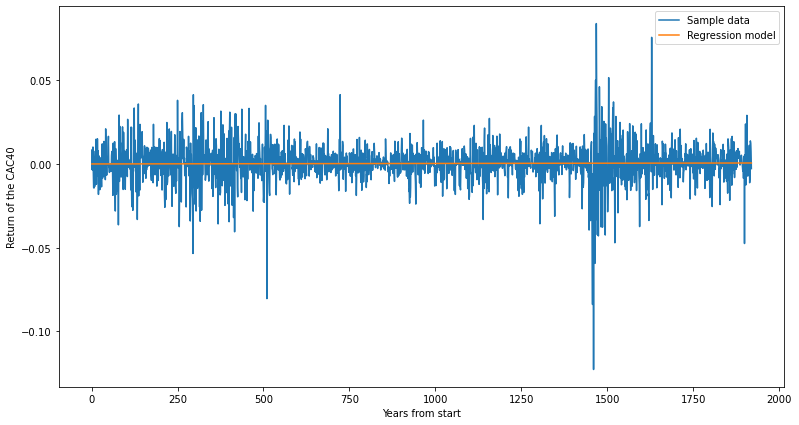

In [29]:
# From these informations, we can generate 2 models : 
# One to predict the prices so the returns and to get the MAs
X_train_price = cac_data_prices[['Time in days']]
X_train_price = X_train_price.iloc[1:]
Y_train_price = return_cac[['CAC40']]
model_price_cac = ols.fit(X_train_price, Y_train_price)
response_price = model_price_cac.predict(X_train_price)

# Try to plot the model and evaluate the goodness of the fit
plt.clf()
fig, ax_price = plt.subplots()
ax_price.plot(X_train_price, Y_train_price, label='Sample data')
ax_price.plot(X_train_price, response_price, label='Regression model')
plt.legend()
plt.xlabel("Years from start")
plt.ylabel("Return of the CAC40")
plt.show()

From this we can already aknowledge that the returns is 0 in average so it may not be interesting to invest in CAC40 but I still want to go through the end of the analysis.

In [30]:
# Creating a list that contains all the days of the predictions
days = []
# Today to (period of investment) days later
for i in range(period_investment):
    days.append(time_position + 128 + i + 1)

In [31]:
# Create the predictions
X_test_ret = pd.DataFrame(days)
Y_predicted_ret = model_price_cac.predict(X_test_ret)
Y_predicted_ret = Y_predicted_ret.tolist()
Y_output = []
for i in range(len(Y_predicted_ret)):
    Y_output.append(Y_predicted_ret[i][0])

# Create the dataframe of the predictions 
data_ret = pd.DataFrame({'Time in days': days, 'Return': Y_output})
data_ret.head()

,Time in days,Return
0,1920,0.000606
1,1921,0.000606
2,1922,0.000606
3,1923,0.000607
4,1924,0.000607


In [32]:
matrix_returns = pd.concat([matrix_returns, data_ret], ignore_index=True)

In [33]:
# Computing the new moving averages
matrix_returns['MA_2'] = matrix_returns['Return'].rolling(window=2, min_periods=2, center=False).mean()
matrix_returns['MA_4'] = matrix_returns['Return'].rolling(window=4, min_periods=4, center=False).mean()
matrix_returns['MA_8'] = matrix_returns['Return'].rolling(window=8, min_periods=8, center=False).mean()
matrix_returns['MA_16'] = matrix_returns['Return'].rolling(window=16, min_periods=16, center=False).mean()
matrix_returns['MA_32'] = matrix_returns['Return'].rolling(window=32, min_periods=32, center=False).mean()
matrix_returns['MA_64'] = matrix_returns['Return'].rolling(window=64, min_periods=64, center=False).mean()
matrix_returns['MA_128'] = matrix_returns['Return'].rolling(window=128, min_periods=128, center=False).mean()

In [34]:
# Create a matrix with the future days only 
future_matrix = matrix_returns[matrix_returns['Time in days'] > time_position + 128]
future_matrix.index = np.arange(0, len(future_matrix))
future_matrix.head()

,Time in days,Return,MA_2,MA_4,MA_8,MA_16,MA_32,MA_64,MA_128
0,1920,0.000606,-0.001074,0.004506,0.002957,0.002997,0.000221,0.001398,0.000720
1,1921,0.000606,0.000606,0.001546,0.001635,0.002108,0.000099,0.001277,0.000669
2,1922,0.000606,0.000606,-0.000234,0.003111,0.000329,-0.000046,0.001384,0.000675
3,1923,0.000607,0.000607,0.000606,0.004207,0.000817,-0.000132,0.001399,0.000662
4,1924,0.000607,0.000607,0.000607,0.002556,0.000911,-0.000132,0.001504,0.000738


Since we have a prediction for the moving averages, we can try to use the linear regression to predict the returns we expect with the moving average factor model. 

In [35]:
# Creating the test and training sets
X_train_return_MA = matrix_considered[['MA_2','MA_4','MA_8','MA_16','MA_32','MA_64','MA_128']].values
Y_train_return_MA = matrix_considered[['Return']]
X_test_return_MA = future_matrix[['MA_2','MA_4','MA_8','MA_16','MA_32','MA_64','MA_128']].values

# Creating the model
model_return = ols.fit(X_train_return_MA, Y_train_return_MA)
Y_test_return_MA = model_return.predict(X_test_return_MA)
Y_out = []
for i in range(len(Y_test_return_MA)):
    Y_out.append(Y_test_return_MA[i][0])
Y_prediction = pd.DataFrame({'Return':Y_out})
Y_prediction['Time in days'] = future_matrix[['Time in days']]

# Replace the values
future_matrix['Return'] = Y_prediction[['Return']]
future_matrix.head()

,Time in days,Return,MA_2,MA_4,MA_8,MA_16,MA_32,MA_64,MA_128
0,1920,-0.001030,-0.001074,0.004506,0.002957,0.002997,0.000221,0.001398,0.000720
1,1921,0.000602,0.000606,0.001546,0.001635,0.002108,0.000099,0.001277,0.000669
2,1922,0.001151,0.000606,-0.000234,0.003111,0.000329,-0.000046,0.001384,0.000675
3,1923,0.001269,0.000607,0.000606,0.004207,0.000817,-0.000132,0.001399,0.000662
4,1924,0.000951,0.000607,0.000607,0.002556,0.000911,-0.000132,0.001504,0.000738


In [36]:
# Since we have the daily return, we can get the cummulative return out of the period
future_matrix['Cummulative returns'] = (1 + future_matrix['Return']).cumprod() - 1
future_matrix.head()

,Time in days,Return,MA_2,MA_4,MA_8,MA_16,MA_32,MA_64,MA_128,Cummulative returns
0,1920,-0.001030,-0.001074,0.004506,0.002957,0.002997,0.000221,0.001398,0.000720,-0.001030
1,1921,0.000602,0.000606,0.001546,0.001635,0.002108,0.000099,0.001277,0.000669,-0.000428
2,1922,0.001151,0.000606,-0.000234,0.003111,0.000329,-0.000046,0.001384,0.000675,0.000722
3,1923,0.001269,0.000607,0.000606,0.004207,0.000817,-0.000132,0.001399,0.000662,0.001992
4,1924,0.000951,0.000607,0.000607,0.002556,0.000911,-0.000132,0.001504,0.000738,0.002946


In [37]:
print("The return we can get out of ", str(period_investment), " days of investment is ", 
      str(round(future_matrix.iloc[-1,-1]*100,2)), "%")

The return we can get out of  30  days of investment is  1.72 %


We can notice that we can get postive cummulative returns for 10 and 30 days of investments but be careful if the user want to change the period of investment they have to rerun all the cells from the part IV- a 2) to avoid errors. Of course, people can choose either to invest in an CAC40 ETF or they can invest in a portfolio of stock that generate a return that is similar to the CAC40 (correlated / cointegrated), but the returns are not really interesting.

#### 3) Finding strongly correlated stocks 
I want to get the top stocks that have returns that are strongly correlated to the CAC40's return and then I will plot the cummulative return of this basket of stocks.

In [38]:
# Parameters
number_of_selection = 4
day_considered_before = 100

In [39]:
matrix_selected = return_cac.iloc[len(return_cac) - day_considered_before - 1:, :]
matrix_selected

,AIRP.PA,AXAF.PA,BOUY.PA,BNPP.PA,TCFP.PA,CAPP.PA,ESLX.PA,OREP.PA,LVMH.PA,MICP.PA,...,VIE.PA,VIV.PA,EUFI.PA,CAGR.PA,MT.AS,ENGIE.PA,LEGD.PA,WLN.PA,STLA.PA,CAC40
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-06,0.001089,0.012831,0.005420,0.030338,-0.006743,0.000528,-0.001805,0.002009,0.000000,-0.000703,...,-0.001455,0.016207,0.002312,0.029160,0.005819,0.002409,-0.002919,0.009444,0.023299,0.005275
2021-08-09,0.000680,0.003801,0.001797,0.003889,-0.007694,0.003428,0.001206,0.000125,0.000000,-0.001407,...,-0.000364,0.005090,0.019514,0.000489,0.005275,0.000343,-0.006274,0.000253,0.006729,-0.000554
2021-08-10,0.006387,0.002945,-0.004484,-0.003505,0.002509,-0.001840,-0.017700,-0.002380,0.006022,0.000000,...,0.004007,-0.001688,-0.011832,-0.002930,0.031144,0.002403,0.008207,-0.015925,-0.000111,0.001032
2021-08-11,0.003781,0.011116,0.009610,0.013884,0.001592,-0.002106,0.000368,0.005400,0.004561,0.003875,...,0.005443,0.016233,-0.000704,0.005877,0.007879,0.010101,0.010645,-0.011816,0.003788,0.005539
2021-08-12,-0.003632,0.006638,0.005949,-0.008216,-0.005224,0.005805,0.004166,0.008868,0.010216,0.002456,...,0.005774,0.003993,0.002996,-0.006654,-0.006840,-0.000508,0.004131,-0.006369,0.024753,0.003570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-20,-0.020550,-0.019701,-0.015951,0.004451,-0.012683,-0.003418,-0.001220,-0.004963,-0.001717,-0.017341,...,-0.007292,-0.003988,0.025920,-0.009162,-0.032415,-0.015434,-0.010851,-0.066775,-0.041404,-0.008161
2021-12-21,0.001203,0.021302,0.006947,0.043247,0.020106,0.000490,0.009215,0.009489,0.005302,0.027206,...,0.007985,0.044929,-0.009520,0.023369,0.028098,0.015206,0.001006,0.047448,0.032299,0.013812
2021-12-22,0.003337,0.004919,0.003285,0.008325,0.015877,0.036239,0.020462,0.009882,0.019815,0.014674,...,0.006654,0.009366,-0.002403,0.006407,0.014366,-0.006949,0.006435,0.012704,0.008589,0.012445


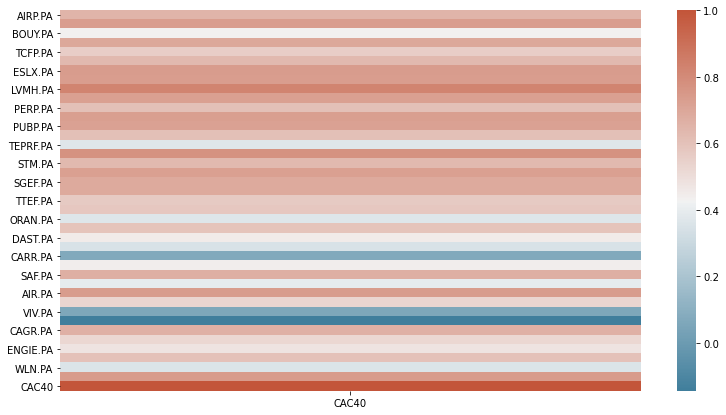

In [40]:
# Create the correlation matrix of this period
corrReturnPeriod = matrix_selected.corr()

# Show
plt.clf()
# Let's show the correlation matrix only for the CAC40
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrReturnPeriod[['CAC40']], annot=False, cmap=cmap)
plt.show()

The good thing we can mention is that the stocks are not anticorrelated to the CAC40, all of them are somehow either not correlated of well correlated we must say that based on this graph, one of the stocks will be LVMH for example.

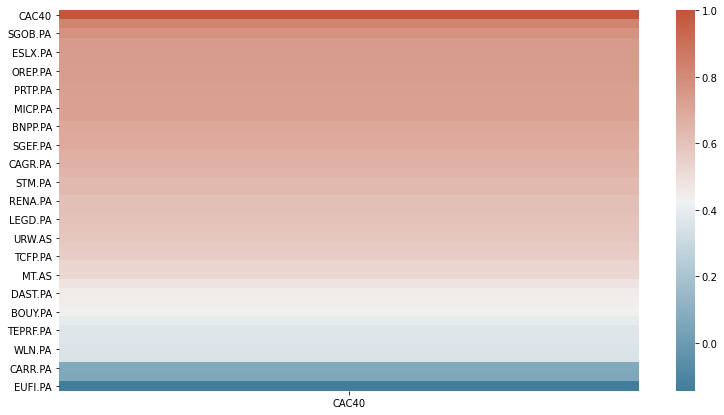

In [41]:
# Let's rank the stocks by their correlation to the CAC40
corrReturnPeriod.sort_values(by = ['CAC40'], axis=0, ascending=False, inplace=True, kind='quicksort')

# plot again to verify
plt.clf()
# Let's show the correlation matrix only for the CAC40
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrReturnPeriod[['CAC40']], annot=False, cmap=cmap)
plt.show()

From what we can say, the stocks are well ordered and therefore we can select the stocks easily.

In [42]:
# Stock selection
list_stock_cac = []
for i in range(number_of_selection):
    list_stock_cac.append(corrReturnPeriod.iloc[i+1,:].name)
list_stock_cac

['LVMH.PA', 'SGOB.PA', 'STLA.PA', 'ESLX.PA']

As said before, we can see that LVMH has the strongest correlation to the CAC40 and the stock is present in the basket of stock that has been created to mimic the CAC40. Let's create a dataframe of the returns of the selected stocks.

In [43]:
frame_cac = pd.DataFrame(columns=list_stock_cac)
for i in range(len(list_stock_cac)):
    frame_cac[[list_stock_cac[i]]] = return_cac[[list_stock_cac[i]]]
# Verify
frame_cac.tail()

,LVMH.PA,SGOB.PA,STLA.PA,ESLX.PA
Date,,,,
2021-12-20,-0.001717,-0.011441,-0.041404,-0.001220
2021-12-21,0.005302,0.020211,0.032299,0.009215
2021-12-22,0.019815,0.015239,0.008589,0.020462
2021-12-23,0.009226,0.018346,0.007056,0.003773
2021-12-24,-0.006371,-0.005896,-0.008215,-0.007088


Let's say that the portfolio is equally weighted (it is not true because usually the stock are weighted by their market capitalization), but since we are missing this data, we will do the analysis with equally weighted basket of stock.

In [44]:
frame_cac['Return port.'] = 0
for i in range(len(list_stock_cac)):
    frame_cac['Return port.'] = frame_cac['Return port.'] + frame_cac[list_stock_cac[i]]
frame_cac['Return port.'] = frame_cac['Return port.']/len(list_stock_cac)
frame_cac.tail()

,LVMH.PA,SGOB.PA,STLA.PA,ESLX.PA,Return port.
Date,,,,,
2021-12-20,-0.001717,-0.011441,-0.041404,-0.001220,-0.013945
2021-12-21,0.005302,0.020211,0.032299,0.009215,0.016757
2021-12-22,0.019815,0.015239,0.008589,0.020462,0.016026
2021-12-23,0.009226,0.018346,0.007056,0.003773,0.009600
2021-12-24,-0.006371,-0.005896,-0.008215,-0.007088,-0.006892


In [45]:
# Let's create the cummulative returns 
frame_cac['Cummulative ret.'] = (1 + frame_cac['Return port.']).cumprod() - 1
frame_cac.tail()

,LVMH.PA,SGOB.PA,STLA.PA,ESLX.PA,Return port.,Cummulative ret.
Date,,,,,,
2021-12-20,-0.001717,-0.011441,-0.041404,-0.001220,-0.013945,1.963959
2021-12-21,0.005302,0.020211,0.032299,0.009215,0.016757,2.013625
2021-12-22,0.019815,0.015239,0.008589,0.020462,0.016026,2.061922
2021-12-23,0.009226,0.018346,0.007056,0.003773,0.009600,2.091316
2021-12-24,-0.006371,-0.005896,-0.008215,-0.007088,-0.006892,2.070010


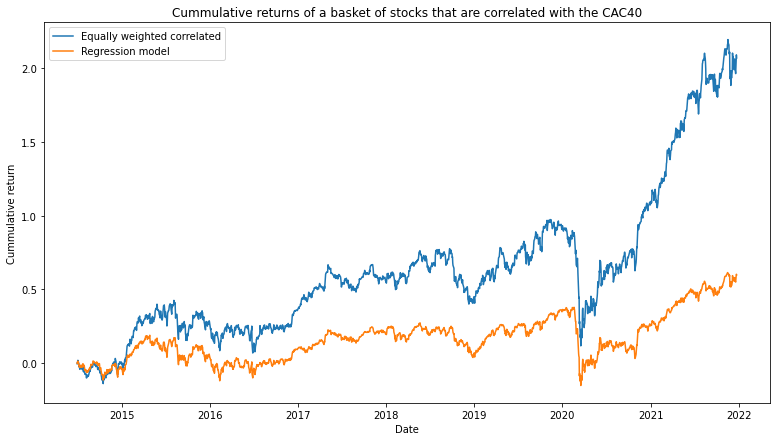

In [46]:
# Let's plot
plt.clf()
plt.plot(frame_cac['Cummulative ret.'], label='Equally weighted correlated')
plt.plot(cummulative_returns['CAC40'], label='Regression model')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cummulative return")
plt.title("Cummulative returns of a basket of stocks that are correlated with the CAC40")
plt.show()

We can say that the pattern is pretty much the same but there is still a difference because we do not take in account the market capitalization, but the pattern is the same. Even if the strategy is likely to beat the CAC40, we can mimic the CAC40 with this strategy. It means that in the CAC40 there are stocks that are pulling down the index and these stock are the ones that are not the one strongly correlated to the CAC40. Therefore, people can invest in this portfolio.

### b. Stock Equity
We will take in account a diversified portfolio with high returns because a good strategy is to diversify the portfolio so we have to take in account uncorrelated stocks. 

In [47]:
# Let's start with taking the stocks with highest cummulative returns
stock_last_return = pd.DataFrame({'Cummulative returns' : cummulative_returns.iloc[-1,], 'Name': cummulative_returns.columns})
stock_last_return.sort_values(by = ['Cummulative returns'], axis=0, ascending=False, 
                              inplace=True, kind='quicksort')
stock_last_return.reset_index(inplace = True)
stock_last_return = stock_last_return[['Name','Cummulative returns']]

stock_last_return.head(10)

,Name,Cummulative returns
0,TEPRF.PA,7.634312
1,STM.PA,5.578987
2,HRMS.PA,4.824314
3,LVMH.PA,4.671720
4,DAST.PA,4.602339
5,EUFI.PA,3.874439
6,PRTP.PA,3.629302
7,CAPP.PA,3.049162
8,OREP.PA,2.354647
9,WLN.PA,2.010366


Now that we have the highest return we want to select some stocks to invest in by basing the investment strategy on high cummulative returns and diversification.

In [48]:
# We would like 4 stocks (value can be changed)
number_of_stock = 4
list_of_stock = []
position = 0

# Create correlation matrix of the returns
corrMatrix = return_cac.iloc[:,:-1].corr()
# Treshold that can be modified
threshold = 0.45
corrMatrix.head()

,AIRP.PA,AXAF.PA,BOUY.PA,BNPP.PA,TCFP.PA,CAPP.PA,ESLX.PA,OREP.PA,LVMH.PA,MICP.PA,...,AIR.PA,VIE.PA,VIV.PA,EUFI.PA,CAGR.PA,MT.AS,ENGIE.PA,LEGD.PA,WLN.PA,STLA.PA
AIRP.PA,1.000000,0.568286,0.530264,0.529947,0.437986,0.517658,0.522800,0.633415,0.633678,0.515782,...,0.483753,0.468309,0.467118,0.370242,0.503312,0.443074,0.542716,0.613303,0.356635,0.497060
AXAF.PA,0.568286,1.000000,0.590008,0.771582,0.515358,0.544157,0.509446,0.491721,0.568127,0.563722,...,0.564761,0.487671,0.455008,0.275418,0.747300,0.555973,0.574446,0.596006,0.358885,0.632800
BOUY.PA,0.530264,0.590008,1.000000,0.616467,0.509542,0.487455,0.463791,0.417401,0.499358,0.531586,...,0.594934,0.467294,0.430861,0.268111,0.603380,0.489307,0.516777,0.551284,0.390286,0.570305
BNPP.PA,0.529947,0.771582,0.616467,1.000000,0.494158,0.487532,0.477482,0.427447,0.548806,0.566463,...,0.597505,0.473669,0.438487,0.214370,0.853801,0.587913,0.555826,0.548285,0.324870,0.642076
TCFP.PA,0.437986,0.515358,0.509542,0.494158,1.000000,0.485884,0.413825,0.417237,0.483435,0.440157,...,0.645003,0.459861,0.344506,0.215282,0.468317,0.371910,0.423602,0.456477,0.406160,0.475416


We want to select the stocks with high cummulative return (that have been ranked right before), and that have a correlation (in absolute value) with the stock already selected that is lower than the threshold. Therefore, we will have the list of the best cummulative return stock that are diversified.

In [49]:
# Create a list of the stock that are selected
# The name of the current stock
name_stock = ''

# While we don't have the number of stock we should have and while we can still go through the tab
while (len(list_of_stock) < number_of_stock) and (position < len(stock_last_return)) :
    # We add the first stock (the one with the highest cummulative return)
    if position == 0 :
        list_of_stock.append(stock_last_return.iloc[0,0])
    else :
        name_stock = stock_last_return.iloc[position,0]
        # Go through the list
        for i in range(len(list_of_stock)):
            # Compare the correlation of the stocks in the list to the current stock 
            if abs(corrMatrix.loc[name_stock, list_of_stock[i]]) < threshold :
                break
            if i == len(list_of_stock) - 1 :
                # If we are still in the loop at the last iteration, we can add the stock to the list of selected stocks
                list_of_stock.append(name_stock)
    position = position + 1

# Here are the stocks we get
print(list_of_stock)

['TEPRF.PA', 'DAST.PA', 'CAPP.PA', 'LEGD.PA']


Alright, since we have the selected stocks, we have to make sure that the algorithm works so I will print the returns of these stocks and the cummulative return of the stocks.

In [50]:
selected_cumm_return = cummulative_returns.loc[:, list_of_stock]
select_ret = return_cac.loc[:, list_of_stock]
select_price = cac_data_prices.loc[:, list_of_stock]

# Print the head of the returns we get
select_ret.head()

,TEPRF.PA,DAST.PA,CAPP.PA,LEGD.PA
Date,,,,
2014-06-30,0.010271,-0.000957,-0.007241,-0.006006
2014-07-01,0.010613,0.019264,0.010557,0.004588
2014-07-02,0.020451,-0.005012,0.004368,-0.002896
2014-07-03,0.010833,0.013223,0.054085,0.014634
2014-07-04,0.006216,0.003832,-0.017582,0.006496


In [51]:
# The cummulative returns of the last day are the following
selected_cumm_return.tail(1)

,TEPRF.PA,DAST.PA,CAPP.PA,LEGD.PA
Date,,,,
2021-12-24,7.634312,4.602339,3.049162,1.253364


<Figure size 936x504 with 0 Axes>

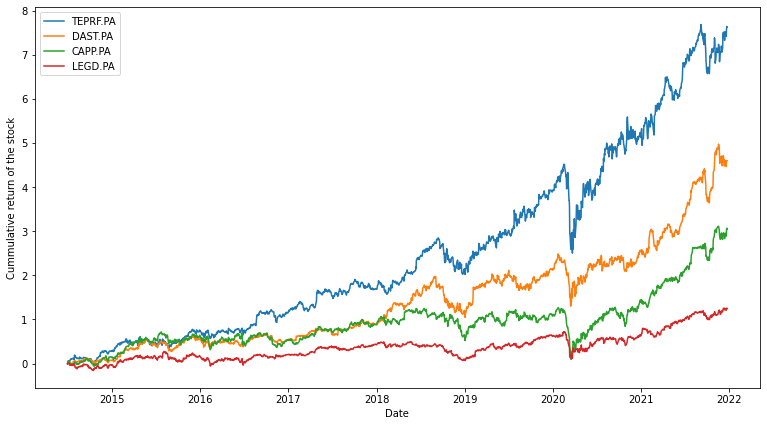

In [52]:
# Let's plot the graph of the stocks that have the best cummulative return and that are not correlated
plt.clf()
fig, ax_ret = plt.subplots()
for i in range(len(list_of_stock)):
    ax_ret.plot(selected_cumm_return.iloc[:, i], label = selected_cumm_return.iloc[:, i].name)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cummulative return of the stock")
plt.show()

#### 1) ARIMA model
Let's try to do an ARIMA model of the current portfolio considering the returns, we try to consider an equally weighted portfolio (for example we invest the same amount in every stock for this strategy).

To find the formula of the return of an equally weighted portfolio, imagine we have a equally weighted portfolio of 100€ invested in each stock, the return are 0%, -10%, -20% and +10%, the return would be 100 * (1 + 0.9 + 0.8 + 1.1)/400 - 1, which can be generalized as (((Amount of portfolio)/(Number of stocks))*(Sum of (returns + 1)))/(Amount of portfolio) - 1, and that can be simplified as :
(SUM of (1 + returns))/(Number of stock) - 1 or (SUM of return + 1 * Number of stocks)/Nb of stocks - 1 or (Sum of return)/(Nb of stock)

In [53]:
# From what has been stated right before
select_ret['Portfolio'] = 0
selected_cumm_return['Portfolio'] = 0
for i in range (len(select_ret.columns)):
    select_ret['Portfolio'] = select_ret['Portfolio'] + select_ret.iloc[:,i]
select_ret['Portfolio'] = select_ret['Portfolio']/len(select_ret.columns)
selected_cumm_return['Portfolio'] = (1 + select_ret['Portfolio']).cumprod() - 1
select_ret.tail()

,TEPRF.PA,DAST.PA,CAPP.PA,LEGD.PA,Portfolio
Date,,,,,
2021-12-20,-0.000268,0.000580,-0.003418,-0.010851,-0.005583
2021-12-21,-0.001339,-0.006182,0.000490,0.001006,-0.002410
2021-12-22,0.019035,0.023717,0.036239,0.006435,0.034170
2021-12-23,0.007630,-0.000570,0.009452,0.013487,0.011999
2021-12-24,-0.001305,0.001140,-0.005150,-0.001479,-0.002718


In [54]:
selected_cumm_return.tail()

,TEPRF.PA,DAST.PA,CAPP.PA,LEGD.PA,Portfolio
Date,,,,,
2021-12-20,7.431151,4.503456,2.889101,1.210210,9.919866
2021-12-21,7.419865,4.469431,2.891006,1.212435,9.893551
2021-12-22,7.580135,4.599149,3.032012,1.226671,10.265785
2021-12-23,7.645598,4.595960,3.070122,1.256701,10.400967
2021-12-24,7.634312,4.602339,3.049162,1.253364,10.369984


<Figure size 936x504 with 0 Axes>

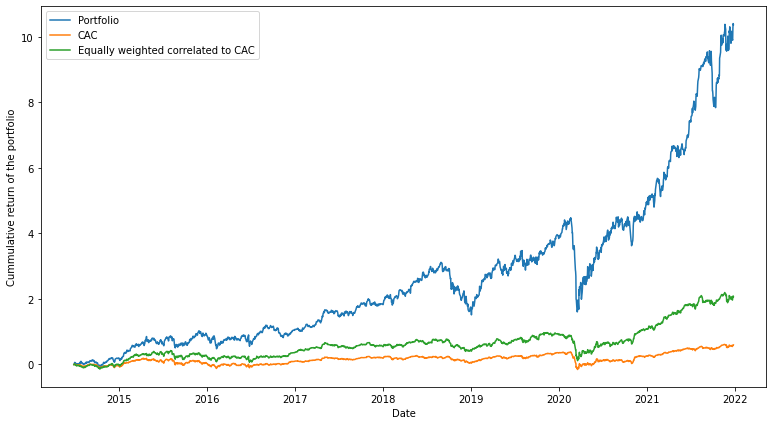

In [55]:
plt.clf()
fig, ax_ret_cum = plt.subplots()
ax_ret_cum.plot(selected_cumm_return[['Portfolio']], label = 'Portfolio')
#for i in range(len(list_of_stock)):
    #ax_ret_cum.plot(selected_cumm_return.iloc[:, i], label = selected_cumm_return.iloc[:, i].name)
ax_ret_cum.plot(cummulative_returns[['CAC40']], label = 'CAC')
ax_ret_cum.plot(frame_cac['Cummulative ret.'], label='Equally weighted correlated to CAC')
plt.legend()
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cummulative return of the portfolio")
plt.show()

This strategy in the long run seems to beat the CAC40 and the other stock, so this strategy may work because the cummulative returns are much higher. I will try to implement an ARIMA model with the returns of the portfolio.

The idea of the ARIMA model is to forecast Time series by combining two existing models that are AutoRegressive model (AR) and the Moving Average model. To perform an ARIMA model, we should verify do the ADF-test to verify that the time series is stationnary. The null hypothesis is that the time series is non stationnary and the alternative hypothesis states that the series is stationnery therefore we can use the ARIMA model.

In [56]:
portfolio_series = select_ret.iloc[1800:,-1]

# run the ADF test
test_result=adfuller(portfolio_series)
print("ADF test statistic : ", str(test_result[0]))
print("p-value : ", str(test_result[1]))

ADF test statistic :  -9.832403054863034
p-value :  4.996873078622162e-17


The critical value of the p-value is 0.05 usually, we reject the null hypothesis when the p-value is lower than the critical value, in our case, the p-value is much lower than 0.05 so we are able to use the ARIMA model because the time series is very likely to be stationnary and it suggest that there will not be a big amount of change, the portfolio may remain stable.

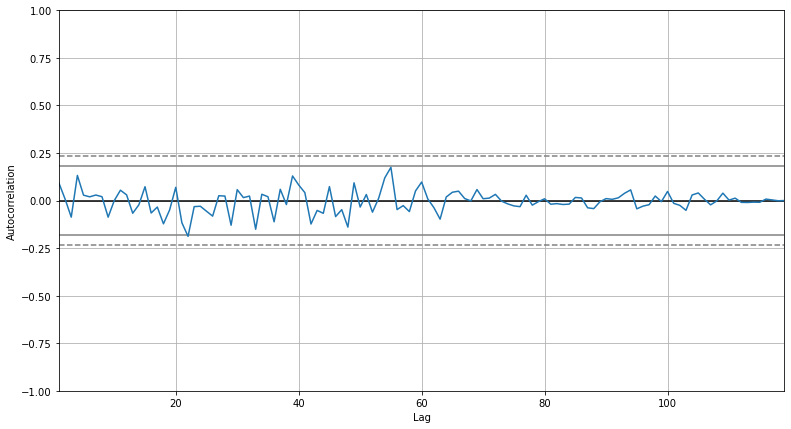

In [57]:
# Autoregressive model
plt.clf()
autocorrelation_plot(portfolio_series)
plt.show()

<Figure size 936x504 with 0 Axes>

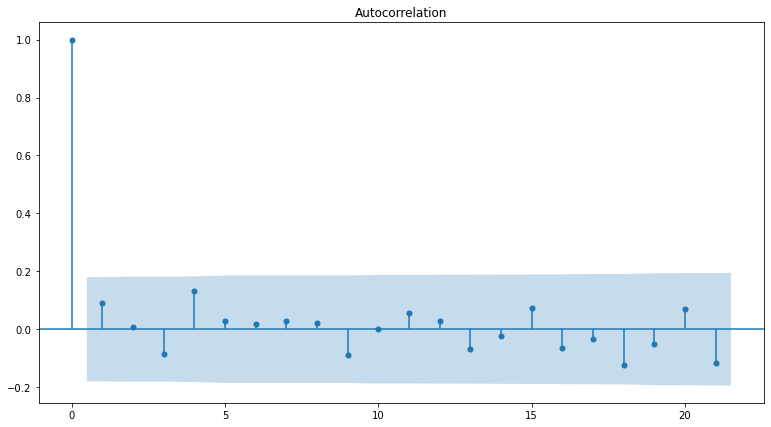

In [58]:
plt.clf()
sm.graphics.tsa.plot_acf(portfolio_series)
plt.show()

As said before, the series is stationnary, and the autocorrelation is likely to stay in the same range, so we can use the autoregressive model.

In [59]:
# Can be changed
p = 1
q = 1
d = 1

model=ARIMA(portfolio_series,order=(p,d,q))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Portfolio   No. Observations:                  118
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 308.867
Method:                       css-mle   S.D. of innovations              0.017
Date:                Thu, 30 Dec 2021   AIC                           -609.734
Time:                        20:54:56   BIC                           -598.651
Sample:                    07-14-2021   HQIC                          -605.234
                         - 12-24-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4.495e-06   5.12e-05     -0.088      0.930      -0.000    9.59e-05
ar.L1.D.Portfolio     0.1003      0.092      1.091      0.275      -0.080       0.280
ma.L1.D.Portfolio    -0.9997      0.028    -35.677      0.000      -1.055      -0.945
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            9.9747           +0.0000j            9.9747            0.0000
MA.1            1.0003           +0.0000j            1.0003            0.0000
-----------------------------------------------------------------------------
"""

<Figure size 936x504 with 0 Axes>

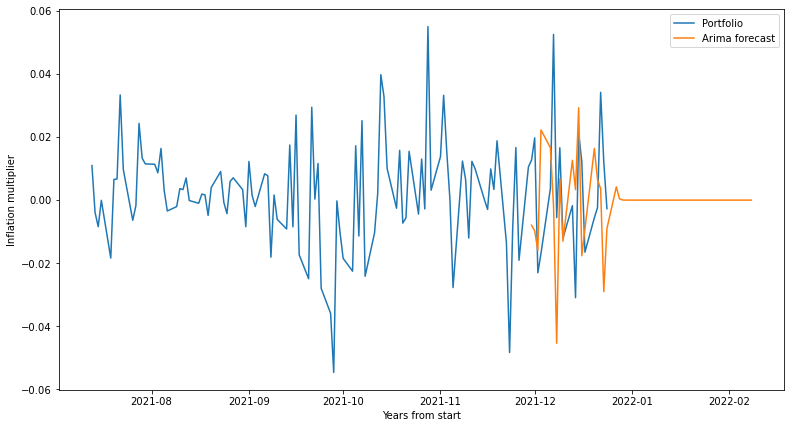

In [60]:
portfolio_series = pd.DataFrame(portfolio_series)
forecast = model_fit.predict(start=100, end=150, dynamic=False)
forecast = pd.DataFrame(forecast)

plt.clf()
fig, ax_arima = plt.subplots()
ax_arima.plot(portfolio_series, label='Portfolio')
ax_arima.plot(forecast, label='Arima forecast')
plt.legend()
plt.xlabel("Years from start")
plt.ylabel("Inflation multiplier")
plt.show()

We can notice that the model is limited because the return did not went as the prediction planned. We can consider that the ARIMA model is not a good model for our portfolio. Because it suggest that in the future the returns would become stable.

#### 2) VaR of the portfolio
In this part I will try to show the empirical Value at Risk of this portfolio at a level of 5% and 1% (confidence 95 and 99% respectively). To do this, I will order the dataframe of the returns of the portfolio by their value and take the value at 5% and the value at 1%.

In [61]:
portfolio_returns = pd.DataFrame(portfolio_series.iloc[:,0])
portfolio_returns.sort_values(by = ['Portfolio'], axis=0, ascending=True, 
                              inplace=True, kind='quicksort')
print("Value at risk 5% : ", str(round(-1*portfolio_returns.iloc[int(round(len(portfolio_returns)*5/100)), 0]*100,2))
      , "% of loss")
print("Value at risk 1% : ", str(round(-1*portfolio_returns.iloc[int(round(len(portfolio_returns)*1/100)), 0]*100,2))
      , "% of loss")

Value at risk 5% :  2.49 % of loss
Value at risk 1% :  4.83 % of loss


The expected risk of a equally weighted portfolio is not very high so we can say that the portfolio does not seem to be very risky in terms of returns.

#### 3) Markowtiz optimization
It is about finiding the efficient frontier of the portfolio and all the combination of stock we can make out of the portfolio with the risk and the return.

In [62]:
def compute_CAGR(prices, annual_days = 256):
    return round((prices.iloc[-1]/prices.iloc[0])**(annual_days/(len(prices)-1))-1,3)

def compute_volatility(returns, annual_days = 256):
    m = returns.mean()
    centered_ret_sq = (returns - m)**2
    sum_sq = centered_ret_sq.sum()
    return round(annual_days**(0.5)*(sum_sq/(len(returns)-1))**(0.5),3)
    

list_stock = select_price.columns.tolist()
list_cagr = []
list_vol = []
for i in range(len(list_stock)):
    list_cagr.append(compute_CAGR(select_price.iloc[:,i]))
    list_vol.append(compute_volatility(select_ret.iloc[:,i]))

In [63]:
# Print the lists
data_markowitz = pd.DataFrame({'Stock':list_stock, 'CAGR' : list_cagr, 'Volatility':list_vol})
data_markowitz

,Stock,CAGR,Volatility
0,TEPRF.PA,0.333,0.271
1,DAST.PA,0.258,0.252
2,CAPP.PA,0.205,0.286
3,LEGD.PA,0.114,0.233


In [64]:
# Covariance matrix of the returns multiplied by 1 year
covMatrix = pd.DataFrame(select_ret.iloc[:,:-1]).cov() * 256
covMatrix

,TEPRF.PA,DAST.PA,CAPP.PA,LEGD.PA
TEPRF.PA,0.073310,0.032765,0.038378,0.029226
DAST.PA,0.032765,0.063400,0.042749,0.026955
CAPP.PA,0.038378,0.042749,0.081535,0.036585
LEGD.PA,0.029226,0.026955,0.036585,0.054355


In [65]:
# Set a big number of portfolio
nb_portfolio = 5000
list_ret = []
list_risk = []
weight = 0
covMatrix = np.asmatrix(covMatrix)

# Create the cagr matrix
matrix_cagr = np.asmatrix(list_cagr)

for i in range(nb_portfolio):
    weights = []
    for j in range(len(list_stock)):
        weights.append(random.uniform(0,10))
    total = sum(weights)
    allocation = []
    for k in range(len(list_stock)):
        allocation.append(weights[k]/total)
    allocation = np.asmatrix(allocation)
    return_port = matrix_cagr*allocation.transpose()
    risk_port = (allocation * (covMatrix * allocation.transpose())).item(0,0)**(0.5)
    list_ret.append(return_port.item(0,0))
    list_risk.append(risk_port)

Since we have the function that allows us to know the efficient frontier of Markowitz, we can plot the graph (the portfolio are generated randomly and these represent all the possible combinations).

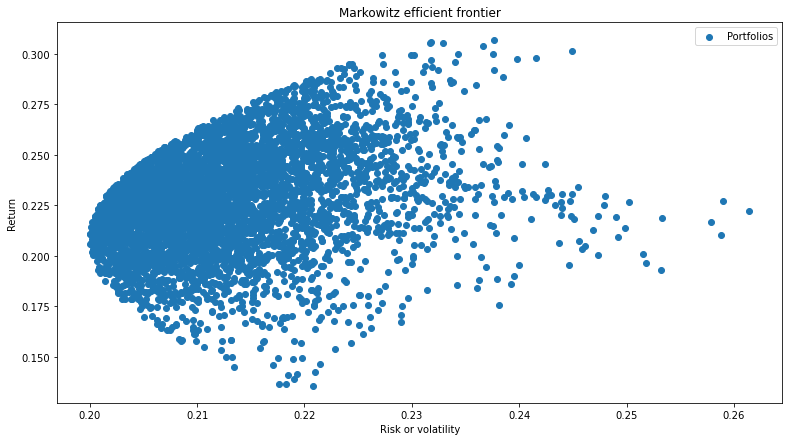

In [66]:
# Plotting the Markowitz efficient frontier
plt.clf()
plt.scatter(list_risk, list_ret, label='Portfolios')
plt.legend()
plt.title("Markowitz efficient frontier")
plt.xlabel("Risk or volatility")
plt.ylabel("Return")
plt.show()

This reprensents the return we can get out of getting a certain amount of risk out of the portfolio created before, to get a return of 30% (which is the maximum in our case), the risk (volatility) rate taken should be at least 22%. Therefore, we do not know if it is worth it to invest in such a portfolio because the cummulative returns are high but the risk and the volatility is also high, so people who invest in this portfolio should accept a risk that is higher than 20%. If one really want to invest in this portfolio, I can do a method that suggest different weight of allocation.

In [67]:
# Matrices that have to be used in this model
vector = np.full((len(list_stock),1),1)
Amat = np.asmatrix(np.concatenate((vector, np.identity(len(list_stock))), axis = 1))
line_vect = np.asmatrix(np.full((1, len(list_stock) + 1),0.0))
line_vect[0,0] = 1.0

In [68]:
gamma = 0.01
# number of observations
obs = len(select_ret)
rolling_window = 20
# Shoulb be higher than 256
start = 300
indexes = range(start, obs, rolling_window)
data_weights = pd.DataFrame(columns = (select_ret.iloc[:,:-1]).columns)
print(data_weights)

for i in indexes :
    # 1 year taken in account
    price_roll = select_price.iloc[i - 256:i,]
    return_roll = select_ret.iloc[i - 256:i,:-1]
    # 1 year CAGR and volatility matrix
    CAGR_1y = []
    vol_1y = []
    total_weight = 0
    weights_val = []
    for j in range(len(list_stock)):
        CAGR_1y.append(compute_CAGR(price_roll.iloc[:,j]))
        vol_1y.append(compute_volatility(return_roll.iloc[:,j]))
    matrix_cagr_temp = np.asmatrix(CAGR_1y)
    matrix_vol_temp = return_roll.cov()
    # Let's use quadratic programming
    qp_out = solvers.qp(matrix(matrix_vol_temp.to_numpy()), matrix(matrix_cagr_temp.transpose()*gamma),
                        matrix(Amat.transpose()), 
                        matrix(line_vect.transpose()))
    total_weight = sum(qp_out['x'])
    for k in range(len(list_stock)):
        # Weight in percentage (1 = the portfolio, 0 = nothing)
        weights_val.append(qp_out['x'][k]/total_weight)
    for l in range(rolling_window):
        data_weights.loc[len(data_weights)] = weights_val
data_weights.index = select_ret.iloc[start-1:,].index
data_weights.tail()

Empty DataFrame
Columns: [TEPRF.PA, DAST.PA, CAPP.PA, LEGD.PA]
Index: []
     pcost       dcost       gap    pres   dres
 0:  2.4858e-03  9.1789e-01  7e+00  3e+00  5e+00
 1: -6.8342e-03 -8.2319e-01  1e+00  4e-01  7e-01
 2: -8.6683e-03 -2.5828e-02  2e-02  9e-03  2e-02
 3: -1.5494e-02 -2.2810e-02  7e-03  4e-03  8e-03
 4: -3.4803e-02 -7.0828e-02  4e-02  1e-14  3e-18
 5: -3.9480e-02 -4.1537e-02  2e-03  0e+00  7e-19
 6: -3.9641e-02 -3.9693e-02  5e-05  7e-15  7e-19
 7: -3.9652e-02 -3.9656e-02  3e-06  8e-15  2e-18
 8: -3.9653e-02 -3.9653e-02  3e-07  5e-15  1e-18
 9: -3.9653e-02 -3.9653e-02  3e-08  4e-15  4e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.7354e-03  9.1768e-01  7e+00  3e+00  5e+00
 1: -7.5553e-03 -8.2411e-01  1e+00  4e-01  7e-01
 2: -9.6040e-03 -2.4426e-02  1e-02  8e-03  1e-02
 3: -1.8382e-02 -2.2453e-02  4e-03  4e-03  6e-03
 4: -3.7212e-02 -5.3486e-02  2e-02  5e-15  2e-18
 5: -3.8711e-02 -4.0152e-02  1e-03  5e-15  7e-19
 6: -3.8865e-02 -3.8886

 1: -3.7112e-03 -8.2261e-01  1e+00  4e-01  7e-01
 2: -4.6760e-03 -2.1417e-02  2e-02  7e-03  1e-02
 3: -7.9688e-03 -1.4136e-02  6e-03  3e-03  6e-03
 4: -1.7216e-02 -7.9072e-02  6e-02  7e-15  1e-18
 5: -2.5458e-02 -4.4404e-02  2e-02  1e-14  1e-18
 6: -2.9563e-02 -3.1150e-02  2e-03  6e-16  2e-18
 7: -3.0022e-02 -3.0114e-02  9e-05  4e-15  4e-19
 8: -3.0055e-02 -3.0056e-02  1e-06  1e-18  1e-18
 9: -3.0055e-02 -3.0055e-02  1e-08  9e-16  1e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3579e-03  9.1803e-01  7e+00  3e+00  5e+00
 1: -6.6972e-03 -8.2382e-01  1e+00  4e-01  7e-01
 2: -8.5754e-03 -2.7741e-02  2e-02  1e-02  2e-02
 3: -1.7533e-02 -2.7151e-02  1e-02  5e-03  1e-02
 4: -6.1298e-02 -1.7753e-01  1e-01  1e-03  2e-03
 5: -4.6322e-02 -1.5293e-01  1e-01  2e-04  4e-04
 6: -7.1261e-02 -8.3903e-02  1e-02  9e-06  2e-05
 7: -7.4744e-02 -7.6108e-02  1e-03  4e-15  1e-18
 8: -7.4945e-02 -7.4990e-02  4e-05  7e-15  4e-19
 9: -7.4949e-02 -7.4951e-02  2e-06  1e-15  1e-

 1: -5.1785e-03 -8.2351e-01  1e+00  4e-01  7e-01
 2: -6.6393e-03 -2.3669e-02  2e-02  8e-03  1e-02
 3: -1.2425e-02 -1.9562e-02  7e-03  4e-03  7e-03
 4: -1.1896e-02 -2.7091e-01  3e-01  6e-04  1e-03
 5:  8.1464e-02 -3.4530e-01  4e-01  3e-04  5e-04
 6: -4.8896e-02 -1.0254e-01  5e-02  8e-15  1e-18
 7: -6.5067e-02 -7.2071e-02  7e-03  5e-15  1e-18
 8: -6.6936e-02 -6.7630e-02  7e-04  9e-16  5e-19
 9: -6.7063e-02 -6.7076e-02  1e-05  7e-15  8e-19
10: -6.7067e-02 -6.7067e-02  1e-07  7e-15  3e-19
11: -6.7067e-02 -6.7067e-02  1e-09  2e-14  4e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9599e-03  9.1838e-01  7e+00  3e+00  5e+00
 1: -5.6930e-03 -8.2468e-01  1e+00  4e-01  7e-01
 2: -7.3309e-03 -2.6152e-02  2e-02  9e-03  2e-02
 3: -1.5486e-02 -2.4468e-02  9e-03  5e-03  9e-03
 4: -8.5000e-02 -2.1357e-01  1e-01  2e-03  4e-03
 5: -6.0255e-02 -2.3040e-01  2e-01  7e-04  1e-03
 6: -9.2524e-02 -1.1167e-01  2e-02  2e-05  4e-05
 7: -9.7241e-02 -9.8507e-02  1e-03  7e-15  5e-

 3: -2.0404e-02 -2.6629e-02  6e-03  4e-03  8e-03
 4: -4.1563e-02 -2.3308e-01  2e-01  3e-04  5e-04
 5: -7.7617e-02 -9.8899e-02  2e-02  6e-06  1e-05
 6: -7.9364e-02 -8.0093e-02  7e-04  8e-15  1e-18
 7: -7.9444e-02 -7.9453e-02  8e-06  8e-15  2e-18
 8: -7.9446e-02 -7.9446e-02  8e-08  8e-15  2e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.6463e-03  9.1697e-01  7e+00  3e+00  5e+00
 1: -1.0571e-02 -8.2539e-01  1e+00  4e-01  7e-01
 2: -1.3661e-02 -3.1604e-02  2e-02  1e-02  2e-02
 3: -3.0424e-02 -3.9455e-02  9e-03  6e-03  1e-02
 4: -9.6926e-02 -1.3160e-01  3e-02  3e-03  6e-03
 5: -1.1407e-01 -1.4902e-01  3e-02  2e-14  1e-18
 6: -1.1854e-01 -1.2056e-01  2e-03  8e-15  1e-18
 7: -1.1877e-01 -1.1880e-01  2e-05  4e-15  7e-19
 8: -1.1878e-01 -1.1878e-01  2e-07  7e-15  9e-19
 9: -1.1878e-01 -1.1878e-01  2e-09  4e-15  8e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.7691e-03  9.1769e-01  7e+00  3e+00  5e+00
 1: -7.9240e-03 -8.2405

 1: -1.1855e-02 -8.2518e-01  1e+00  4e-01  7e-01
 2: -1.5390e-02 -3.0915e-02  2e-02  1e-02  2e-02
 3: -3.6784e-02 -4.2887e-02  6e-03  6e-03  1e-02
 4: -1.2846e-01 -2.1159e-01  8e-02  1e-03  2e-03
 5: -1.1825e-01 -2.0264e-01  8e-02  9e-05  2e-04
 6: -1.3352e-01 -1.4393e-01  1e-02  5e-06  9e-06
 7: -1.3504e-01 -1.3586e-01  8e-04  5e-15  1e-18
 8: -1.3507e-01 -1.3508e-01  1e-05  6e-15  1e-18
 9: -1.3507e-01 -1.3507e-01  1e-07  8e-15  4e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.1741e-03  9.1736e-01  7e+00  3e+00  5e+00
 1: -9.2086e-03 -8.2461e-01  1e+00  4e-01  7e-01
 2: -1.1886e-02 -3.1453e-02  2e-02  1e-02  2e-02
 3: -2.6115e-02 -3.6718e-02  1e-02  6e-03  1e-02
 4: -8.4584e-02 -1.9135e-01  1e-01  9e-04  2e-03
 5: -7.6775e-02 -1.6813e-01  9e-02  3e-04  5e-04
 6: -9.2761e-02 -1.0301e-01  1e-02  1e-05  2e-05
 7: -9.5040e-02 -9.6145e-02  1e-03  8e-15  5e-19
 8: -9.5185e-02 -9.5248e-02  6e-05  1e-14  1e-18
 9: -9.5191e-02 -9.5195e-02  4e-06  1e-14  6e-

,TEPRF.PA,DAST.PA,CAPP.PA,LEGD.PA
Date,,,,
2021-12-20,6.564002e-10,0.43992,0.418851,0.141229
2021-12-21,6.564002e-10,0.43992,0.418851,0.141229
2021-12-22,6.564002e-10,0.43992,0.418851,0.141229
2021-12-23,6.564002e-10,0.43992,0.418851,0.141229
2021-12-24,6.564002e-10,0.43992,0.418851,0.141229


The tail value is the allocation of portfolio the investor should be having at this stage to optimize the return of his portfolio. I can do a verification with the returns.

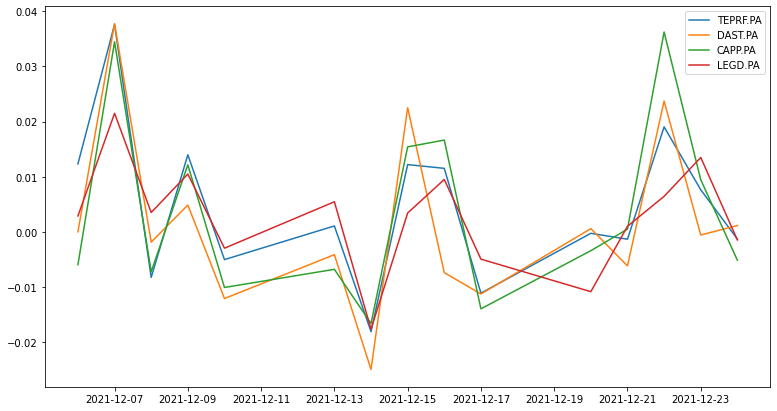

In [69]:
# Plotting the tail returns
plt.clf()
plt.plot(select_ret.iloc[:,0].tail(15), label =select_ret.iloc[:,0].name)
plt.plot(select_ret.iloc[:,1].tail(15), label =select_ret.iloc[:,1].name)
plt.plot(select_ret.iloc[:,2].tail(15), label =select_ret.iloc[:,2].name)
plt.plot(select_ret.iloc[:,3].tail(15), label =select_ret.iloc[:,3].name)
plt.legend()

From what we can see, the amplitude of Dassault Systemes and Capgemini are the highest so it means that they are evolving the most and they reach the highest returns therefore it is naturally normal to have this allocation of portfolio at the end.

<Figure size 936x504 with 0 Axes>

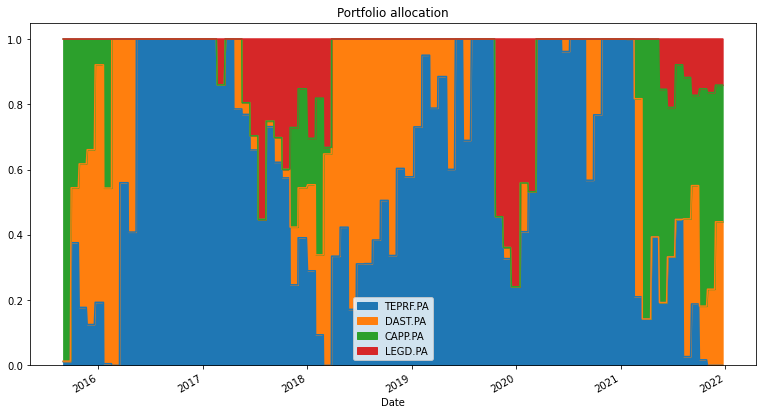

In [70]:
# Let's plot the plot that describe how the portfolio should be allocate over time
plt.clf()
data_weights.plot.area()
plt.title("Portfolio allocation")
plt.legend()

We can try to compute the returns of the portfolio be multiplying the returns by the weights and create the cummulative return of the new portfolio, compare it to the old one.

In [71]:
# Let's create the dataframe that contains the returns
zero_data = np.zeros(shape=(len(data_weights),len(list_stock)))
return_op_port = pd.DataFrame(zero_data,columns = (select_ret.iloc[:,:-1]).columns)
for i in range(len(list_stock)):
    for j in range(len(data_weights)):
        return_op_port.iloc[j,i] = select_ret.iloc[start-1+j,i] * data_weights.iloc[j,i]
return_op_port.index = data_weights.index
return_op_port['Return'] = 0
for i in range(len(list_stock)):
    return_op_port['Return'] = return_op_port['Return'] + return_op_port.iloc[:,i]
return_op_port[['Return']].tail()
return_port = pd.DataFrame(select_ret.iloc[start-1:,-1])

In [72]:
# Cummulative return of the new strategy
cummul_op_port = (1 + return_op_port[['Return']]).cumprod() - 1
cummul_port = (1 + select_ret.iloc[start-1:,-1]).cumprod() - 1

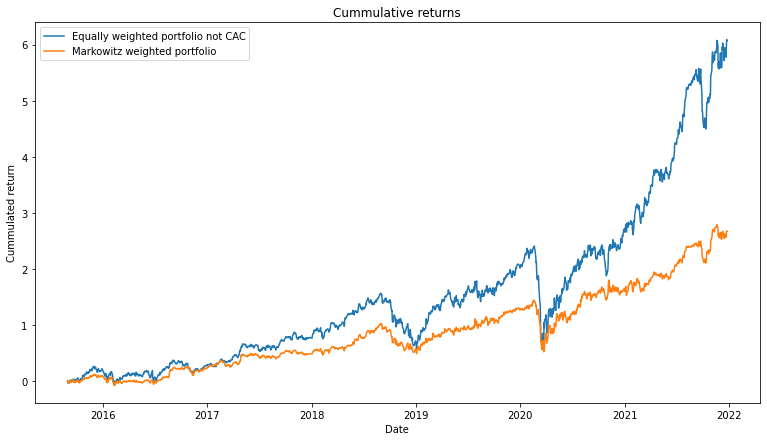

In [73]:
# Plotting the cummulative return of the optimized portfolio
plt.clf()
plt.plot(cummul_port, label="Equally weighted portfolio not CAC")
plt.plot(cummul_op_port, label="Markowitz weighted portfolio")
plt.title("Cummulative returns")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cummulated return")
plt.show()

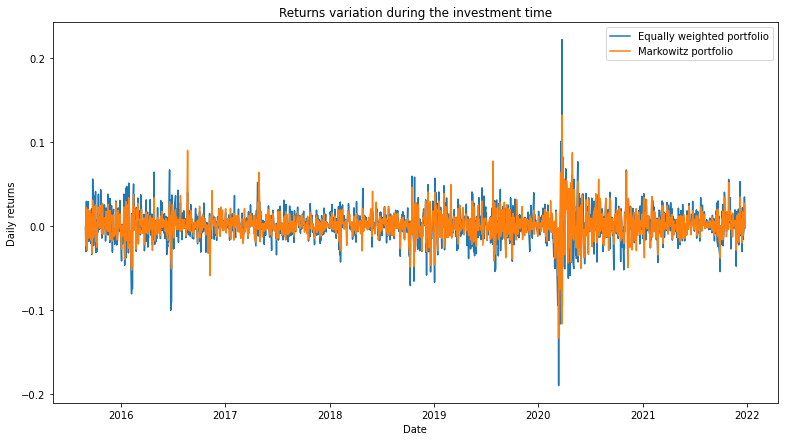

In [74]:
# Let's try to see the returns
plt.clf()
plt.plot(return_port, label="Equally weighted portfolio")
plt.plot(return_op_port[['Return']], label="Markowitz portfolio")
plt.title("Returns variation during the investment time")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Daily returns")
plt.legend()
plt.show()

From what we can say, the optimized portfolio is less risky but still allows to have a similar trend in the cummulative returns. However the variations are lower (the returns are less volatile) and it may be a solution for people that do not accept a high volatility in their portfolio. We can compare the result of the cummulative returns of the CAC40 too.

In [75]:
# Taking the dates that have been considered in the portfolio
return_cac40 = pd.DataFrame(return_cac.iloc[start-1:,-1])
# Verify the dates
return_cac40.head()

,CAC40
Date,
2015-08-31,-0.004744
2015-09-01,-0.024026
2015-09-02,0.003030
2015-09-03,0.021706
2015-09-04,-0.028087


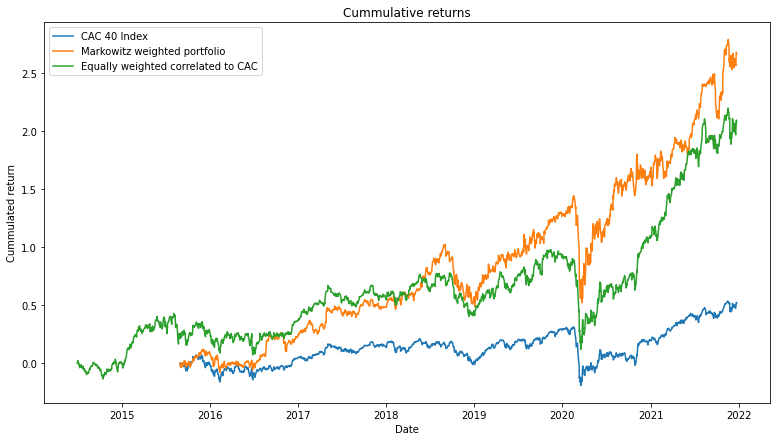

In [76]:
# Cummulative returns
cummul_cac40 = (1 + return_cac40[['CAC40']]).cumprod() - 1
plt.clf()
plt.plot(cummul_cac40, label="CAC 40 Index")
plt.plot(cummul_op_port, label="Markowitz weighted portfolio")
plt.plot(frame_cac['Cummulative ret.'], label='Equally weighted correlated to CAC')
plt.title("Cummulative returns")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cummulated return")
plt.show()

This strategy is still better than the CAC40 because the slope in bigger and the trend is clearly an upward trend so one can invest in a portfolio that is weighted in this manner (by the Markowitz optimization) and for the moment, it can be interesting to hold Capgemini and Dassault Systemes. The portfolio also tends to beat the basket of stock that have been chosen to mimic the CAC40. Therefore, it can be a good solution.

## V. FOREX
This part will be about the FOREX we have seen in the part II already with the first plots. The idea is to choose the currencies for whichi the EUR/?? is going down because that will mean either the currency is gaining value or that EUR is loosing value. I will choose GBP, USD or HKD based on the graphs that have been shown before because the JPY seems to have a high volatility and the returns are quite uncertain.

In [77]:
forex_data = pd.DataFrame({'EUR/GBP': eurgbp['Close'], 'EUR/USD':eurusd['Close'], 'EUR/HKD':eurhkd['Close']})
forex_data = forex_data[pd.notna(forex_data['EUR/GBP'])]

In [78]:
# Create a correlation plot, it is irrelevant to have many currencies that are correlated
corrForex = forex_data.corr()
corrForex

,EUR/GBP,EUR/USD,EUR/HKD
EUR/GBP,1.000000,0.705163,0.699525
EUR/USD,0.705163,1.000000,0.999393
EUR/HKD,0.699525,0.999393,1.000000


We can select the two currencies that are the less correlated for example GBP and HKD, one can invest in the two of them in order to get higher returns.

In [79]:
chosen_FOREX = forex_data[['EUR/GBP', 'EUR/HKD']]

# Create the returns (inverted for FOREX, we take the negative of the return, the lower the price, the higher return)
ret_data = -forex_data.pct_change()
ret_chosen = -chosen_FOREX.pct_change()

# eliminate the first value which is nan
ret_data = ret_data.iloc[1:]
ret_chosen = ret_chosen.iloc[1:]

In [80]:
# Create the portfolio of returns
ret_data['Total'] = 0
ret_chosen['Total'] = 0
for i in range(len(ret_data.columns)-1):
    ret_data['Total'] = ret_data['Total'] + ret_data.iloc[:, i]
for i in range(len(ret_chosen.columns)-1):
    ret_chosen['Total'] = ret_chosen['Total'] + ret_chosen.iloc[:, i]
ret_data['Total'] = ret_data['Total']/3
ret_chosen['Total'] = ret_chosen['Total']/2

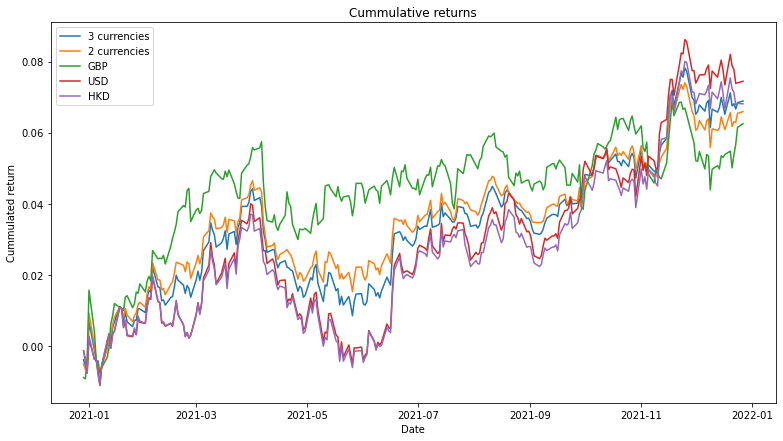

In [81]:
# Cummulative returns
data_cumm = (1 + ret_data).cumprod() - 1
chose_cumm = (1 + ret_chosen).cumprod() - 1

# Plot
plt.clf()
plt.plot(data_cumm['Total'], label="3 currencies")
plt.plot(chose_cumm['Total'], label="2 currencies")
plt.plot(data_cumm['EUR/GBP'], label="GBP")
plt.plot(data_cumm['EUR/USD'], label="USD")
plt.plot(data_cumm['EUR/HKD'], label="HKD")
plt.title("Cummulative returns")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cummulated return")
plt.show()

We can see that in average, investing in two currencies might be a good solution and if one want to invest in only on currency, they could have chosen the GBP before but the trend tends to remain stable for the moment. From the beginning of the year if one has invested in HKD and USD they would have followed the same pattern so this is why diversifying the investment strategies is important. We will keep going on with the 2 currencies strategy by doing a linear regression since the model seems to be linear.

In [82]:
# Starting with the moving average to see the trend
chose_cumm['10 days'] = chose_cumm['Total'].rolling(window=10, min_periods=10, center=False).mean()
chose_cumm['50 days'] = chose_cumm['Total'].rolling(window=50, min_periods=50, center=False).mean()

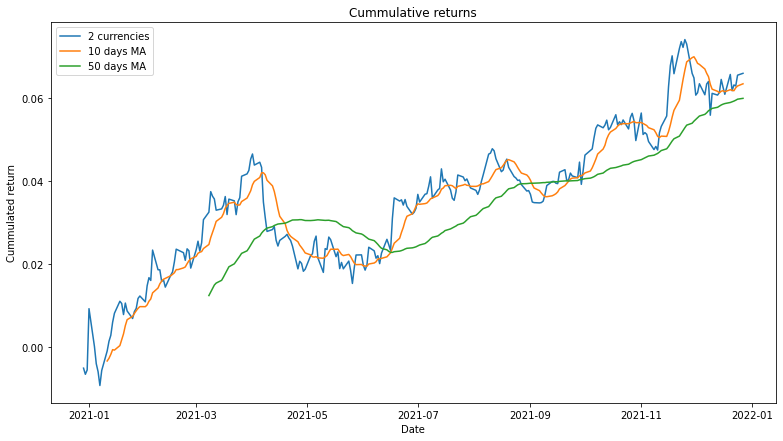

In [83]:
plt.clf()
plt.plot(chose_cumm['Total'], label="2 currencies")
plt.plot(chose_cumm['10 days'], label="10 days MA")
plt.plot(chose_cumm['50 days'], label="50 days MA")
plt.title("Cummulative returns")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cummulated return")
plt.show()

We can clearly state that the trend can be modelled as a linear model because when whe try to smooth the graph, it starts to become a line very fast and the trend is very clear.

In [84]:
chose_cumm.reset_index(inplace = True)

In [85]:
# Try to set the days from start to implement linear regression
chose_cumm['days'] = chose_cumm.index
chose_cumm

,Date,EUR/GBP,EUR/HKD,Total,10 days,50 days,days
0,2020-12-29,-0.008964,-0.001373,-0.005168,NaN,NaN,0
1,2020-12-30,-0.009324,-0.003984,-0.006650,NaN,NaN,1
2,2020-12-31,-0.003615,-0.007632,-0.005607,NaN,NaN,2
3,2021-01-01,0.015642,0.002679,0.009169,NaN,NaN,3
4,2021-01-04,0.003878,-0.003827,0.000050,NaN,NaN,4
...,...,...,...,...,...,...,...
255,2021-12-21,0.050066,0.072274,0.061705,0.061783,0.059028,255
256,2021-12-22,0.053769,0.071284,0.063087,0.061699,0.059198,256
257,2021-12-23,0.056680,0.067837,0.062845,0.062404,0.059409,257
258,2021-12-24,0.061476,0.068209,0.065442,0.062842,0.059661,258


In [86]:
X_train_forex = chose_cumm[['days']]
Y_train_forex = chose_cumm[['Total']]
model_forex = ols.fit(X_train_forex, Y_train_forex)
response_forex = model_forex.predict(X_train_forex)

<Figure size 936x504 with 0 Axes>

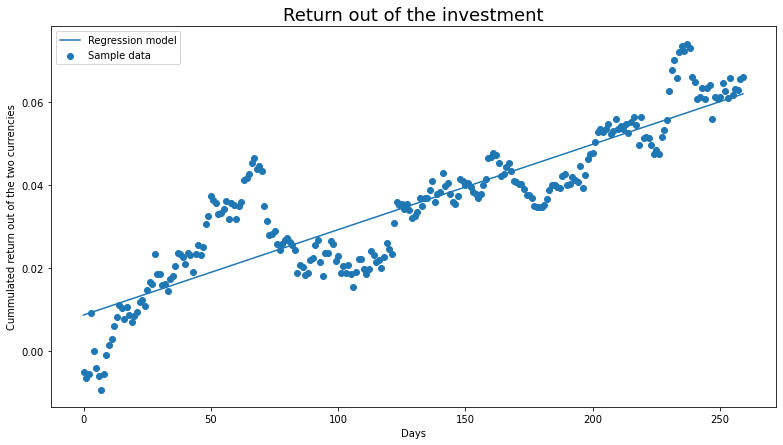

In [87]:
# Plot
plt.clf()
fig, ax_forex = plt.subplots()
ax_forex.plot(X_train_forex, response_forex, label='Regression model')
ax_forex.scatter(X_train_forex, Y_train_forex, label='Sample data')
ax_forex.set_title('Return out of the investment', fontsize=18)
plt.legend()
plt.xlabel("Days")
plt.ylabel("Cummulated return out of the two currencies")
plt.show()

In [88]:
# Select days 
select_days_of_investment = 15

# Predictions
prediction = model_forex.predict(select_days_of_investment + chose_cumm.iloc[-1,-1].reshape(1, -1))
prediction_today = model_forex.predict(chose_cumm.iloc[-1,-1].reshape(1, -1))
print("If you invest today for ", select_days_of_investment, "days you may get a return of ", 
      str(round((prediction - 
                 prediction_today)[0][0]*100,2))
      , "%")

If you invest today for  15 days you may get a return of  0.31 %


## Conclusion
I did not manage to do the alpha cointegration because the project is very long already. I have set the code in a way such that the user can modify the parameter easily if they want to test some things. the conclusion we can mae is that it is better to invest in long term US bonds, have a diversified portfolio, not only basing ourselves on an index because the CAC40 does not allow big returns. We can use Markowitz optimization to allocate the portfolio in a less risky way and by keeping a right amount of return. About the forex, it is better to invest in currencies that are not correlated and when the price is going up (GBP / HKD) in other to diversify the incomes. It is a pity that I did not have enough time to cover the Alpha cointegration, I have done a research project on based this article, with a Python code, the report is in French. Please let me know in case you want to know more. Of course, the investment strategy I have shown in this project is very limited and the predictions are limited too because if I knew an investment strategy that works, I would not a student anymore.